In [567]:
!pip install pyomo
!wget https://people.montefiore.uliege.be/cornelusse/utils/ampl.linux-intel64.zip
!unzip /content/ampl.linux-intel64.zip
!chmod +x /content/ampl.linux-intel64/ipopt # To make sure it can be executed
!chmod +x /content/ampl.linux-intel64/cbc # To make sure it can be executed

--2025-08-25 14:43:07--  https://people.montefiore.uliege.be/cornelusse/utils/ampl.linux-intel64.zip
Resolving people.montefiore.uliege.be (people.montefiore.uliege.be)... 139.165.57.148
Connecting to people.montefiore.uliege.be (people.montefiore.uliege.be)|139.165.57.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486900 (17M) [application/zip]
Saving to: ‘ampl.linux-intel64.zip.4’

ampl.linux-intel64. 100%[===================>]  16.68M  5.76MB/s    in 2.9s    

2025-08-25 14:43:12 (5.76 MB/s) - ‘ampl.linux-intel64.zip.4’ saved [17486900/17486900]

Archive:  /content/ampl.linux-intel64.zip
replace __MACOSX/._ampl.linux-intel64? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [568]:
!pip install pandapower --upgrade

In [569]:
!pip install networkx

In [570]:
!pip install gurobipy  # install gurobipy, if not already installed

In [571]:
import gurobipy as gp
import time
import pandas as pd
import xarray as xr
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pyomo.environ as pyo
import math
import pandapower as pp


# Create a new graph
G = nx.DiGraph()

In [572]:
import pandapower.networks as pn
import pandapower as pp

def modified_case_14():
    net = pn.case14()

    # Find line indices for (9,10) and (13,14)
    line_idx = net.line[
        ((net.line.from_bus == 8) & (net.line.to_bus == 9)) |   # buses are 0-based in pandapower
        ((net.line.from_bus == 12) & (net.line.to_bus == 13))
    ].index

    # Find trafo index for (7,9)
    trafo_idx = net.trafo[
        ((net.trafo.hv_bus == 6) & (net.trafo.lv_bus == 8))
    ].index

    # Drop them
    pp.drop_lines(net, line_idx)
    pp.drop_trafos(net, trafo_idx)

    return net

net = modified_case_14()


In [573]:
import pandapower.plotting.plotly as ppply

# Create an interactive plot with voltage information on hover
ppply.pf_res_plotly(net, filename="interactive_network_plot.html", cmap='viridis')

In [574]:
import pandapower.plotting.plotly as ppply

# Create an interactive plot with voltage information on hover
ppply.pf_res_plotly(pn.case14(), filename="interactive_network_plot.html", cmap='viridis')

In [575]:
s_base = 100 #MVA

In [576]:
def calculate_current_bounds(v_base):
    """
    Calculates the upper and lower bounds for current in per-unit
    based on the line type's maximum current capacity.

    Args:
        line_type (str): The type of the transmission line.
        i_base_kA (float): The base current in kA for the system.

    Returns:
        tuple: A tuple containing (I_min_pu, I_max_pu).
               Returns (None, None) if the line type is not found.
    """
    # Define a dictionary mapping line types to their maximum current capacity in kA
    # NOTE: This is a placeholder. You should populate this dictionary
    # with the actual maximum current capacities for your line types.
    i_base_kA = s_base / (math.sqrt(3) * v_base) # kA


    max_current_kA = {
        135: 0.96, # Example value for 110 kV lines
        14: 0.535, # Example value for 20 kV lines
        0.208: 0.35 # Example value for 0.4 kV lines
    }

    if v_base in max_current_kA:
        I_max_kA = max_current_kA[v_base]

        # Calculate the upper bound for current in per-unit
        I_max_pu = I_max_kA / i_base_kA

        # The lower bound for current is the negative of the upper bound
        I_min_pu = -I_max_pu

        return I_min_pu, I_max_pu

    elif v_base not in max_current_kA:
        return -1000, 1000
    else:
        return None, None


#I_min_line1, I_max_line1, i_base_kA = calculate_current_bounds(line1_type, i_base_high)

# line4_type = 'NA2XS2Y 1x185 RM/25 12/20 kV'
I_min_line4, I_max_line4 = calculate_current_bounds(14)
print([{I_min_line4}, {I_max_line4}])

[{-0.12973060548690893}, {0.12973060548690893}]


In [577]:
def create_graph(net) -> nx.Graph:
    import json
    # -------------------------
    # 1. Conversion du réseau Pandapower en DiGraph
    # -------------------------
    G = nx.Graph()

    # 2. Récupération des positions à partir de la colonne 'geo'
    pos = {}
    for idx, row in net.bus.iterrows():
        geo_data = row['geo']
        if geo_data is None:
            raise ValueError(f"Le bus '{row['name']}' (index {idx}) n'a pas de coordonnées 'geo'.")
        geo_dict = json.loads(geo_data)
        coordinates = geo_dict["coordinates"]
        pos[idx] = tuple(coordinates)

    #Ajouter une puissance de base
    G.graph["s_base"] = 100.0 # MVA
    G.graph["v_base"] = 110.0 # kV

    # Ajouter les nœuds
    for idx, row in net.bus.iterrows():
        G.add_node(idx,
                   label=row["name"],
                   pos=pos[idx],
                   vn_kv=row["vn_kv"])

    # Ajouter les arêtes pour les lignes
    for _, row in net.line.iterrows():
        G.add_edge(row["from_bus"], row["to_bus"],
                   type="line",
                   name=row["name"],
                   length=row["length_km"],
                   std_type=row["std_type"],
                   x_ohm=row["x_ohm_per_km"],)

    # Ajouter les arêtes pour les transformateurs
    for _, row in net.trafo.iterrows():
        G.add_edge(row["hv_bus"], row["lv_bus"],
                   type="trafo", std_type = None,
                   name=row["name"])

    # Ajouter les générateurs et les charges comme attributs aux nœuds
    for _, row in net.gen.iterrows():
        G.nodes[row["bus"]]["type"] = "gen"
        G.nodes[row["bus"]]["gen_name"] = row["name"]
        G.nodes[row["bus"]]["gen_power"] = row["p_mw"]

    for _, row in net.load.iterrows():
        G.nodes[row["bus"]]["type"] = "load"
        G.nodes[row["bus"]]["load_name"] = row["name"]
        G.nodes[row["bus"]]["load_power"] = row["p_mw"]

    for _, row in net.ext_grid.iterrows():
        G.nodes[row["bus"]]["type"] = "ext_grid"
        G.nodes[row["bus"]]["grid_name"] = row["name"]

    # -------------------------
    # 2. Manually define power demand and add to nodes
    # -------------------------
    # Manually define the 'P' attribute for each node in the graph G
    # Example:
    co = 4
    power_demand = {
        0: 0.0/co,
        1: 50,
        2: -20,
        3: 0/co,
        4: 0/co,
        5: -1e-1/co,
        6: 0.1/co,
        7: -0.2/co,
        8: -29.5*1e-2 /co,
        9: -9.0*1e-1 /co,
        10: -3.5*1e-1 /co,
        11: -6.1*1e-1 /co,
        12: -13.5*1e-2 /co,
        13: -14.9*1e-2 /co
    }

    for n in G.nodes:
        G.nodes[n]["P"] = power_demand.get(n, 0.0) # Use get with a default value of 0.0
        G.nodes[n]["P_pu"] = G.nodes[n]["P"]/s_base
    print(net.line.columns)

    # Calculate the susceptance and max_current of each line in Siemens
    for u, v, data in G.edges(data=True):
        if data.get('type') == 'trafo':
             # Assign a high max_current for transformers
             data['max_current_pu'] = 1000 # Use a large value
             print(f"Transformer {u}->{v}: max_current_pu = {data['max_current_pu']} pu (high value)")
        else:
            data['b_pu'] = (G.nodes[u]["vn_kv"]**2 / (data['x_ohm'] * G.graph["s_base"]))  # Calcule et stocke B_ij per unit
            print(f"Ligne {u}->{v}: b_pu = {G[u][v]['b_pu']} pu")

            # Calculate max_current for lines based on line type and node voltage
            line_type = data.get('std_type')
            v_node_kv = G.nodes[u].get("vn_kv") # Get voltage of the 'from' node

            if v_node_kv is not None:
                I_min_pu, I_max_pu = calculate_current_bounds(v_node_kv)
                if I_max_pu is not None:
                    data['max_current_pu'] = I_max_pu
                    print(f"Line {u}->v: max_current_pu = {data['max_current_pu']} pu")
                else:
                    print(f"Warning: Could not calculate max_current for line {u}->{v} (unknown line type or voltage).")
                    data['max_current_pu'] = None # Or a default value if appropriate
            else:
                 print(f"Warning: Missing line type or node voltage for line {u}->{v}. Could not calculate max_current.")
                 data['max_current_pu'] = None # Or a default value if appropriate


    B_base = G.graph["s_base"]/(G.graph["v_base"]**2)
    print("B_base: ", B_base)

    # -------------------------
    # Donner accès à G
    # -------------------------
    node_attrs = {n: G.nodes[n] for n in G.nodes}
    return G # Return G and the plot_network function

In [578]:
G = create_graph(net)
print(f"Value of G.nodes[11]['P'] after updating G: {G.nodes[11]['P']}")

Index(['name', 'std_type', 'from_bus', 'to_bus', 'length_km', 'r_ohm_per_km',
       'x_ohm_per_km', 'c_nf_per_km', 'g_us_per_km', 'max_i_ka', 'df',
       'parallel', 'type', 'in_service', 'max_loading_percent', 'geo'],
      dtype='object')
Ligne 0->1: b_pu = 16.900456312320436 pu
Line 0->v: max_current_pu = 2.2447378466092647 pu
Ligne 0->4: b_pu = 4.483500717360115 pu
Line 0->v: max_current_pu = 2.2447378466092647 pu
Ligne 1->2: b_pu = 5.051270394504217 pu
Line 1->v: max_current_pu = 2.2447378466092647 pu
Ligne 1->3: b_pu = 5.671506352087114 pu
Line 1->v: max_current_pu = 2.2447378466092647 pu
Ligne 1->4: b_pu = 5.751092707614446 pu
Line 1->v: max_current_pu = 2.2447378466092647 pu
Ligne 2->3: b_pu = 5.846927439630474 pu
Line 2->v: max_current_pu = 2.2447378466092647 pu
Ligne 3->4: b_pu = 23.747328425552126 pu
Line 3->v: max_current_pu = 2.2447378466092647 pu
Transformer 3->6: max_current_pu = 1000 pu (high value)
Transformer 3->8: max_current_pu = 1000 pu (high value)
Transformer 4

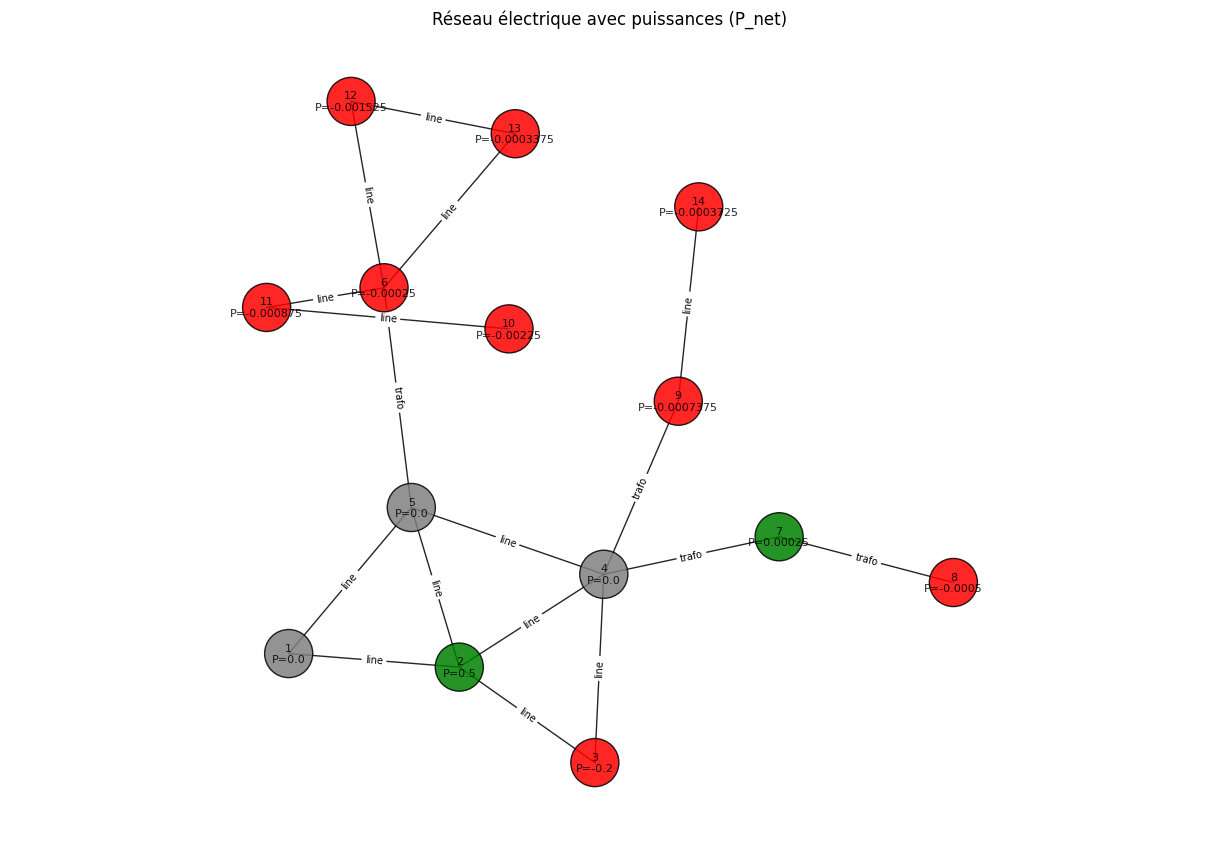

In [579]:
# 3. Préparer les couleurs des nœuds en fonction de P_net
# ================================
node_colors = []
for n, data in G.nodes(data=True):
    if G.nodes[n]["P"] > 0:
        node_colors.append("green")   # producteur
    elif G.nodes[n]["P"] < 0:
        node_colors.append("red")     # consommateur
    else:
        node_colors.append("gray")    # neutre

# 4. Préparer les labels : Nom + P_net
# ================================
labels = {n: f"{data['label']}\nP={round(G.nodes[n]["P_pu"],7)}"
          for n, data in G.nodes(data=True)}

def plot_network():
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))
      nx.draw(
          G, pos,
          with_labels=True, labels=labels,
          node_size=1200, node_color=node_colors,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique avec puissances (P_net)")
      plt.axis("equal")
      plt.show()
plot_network()

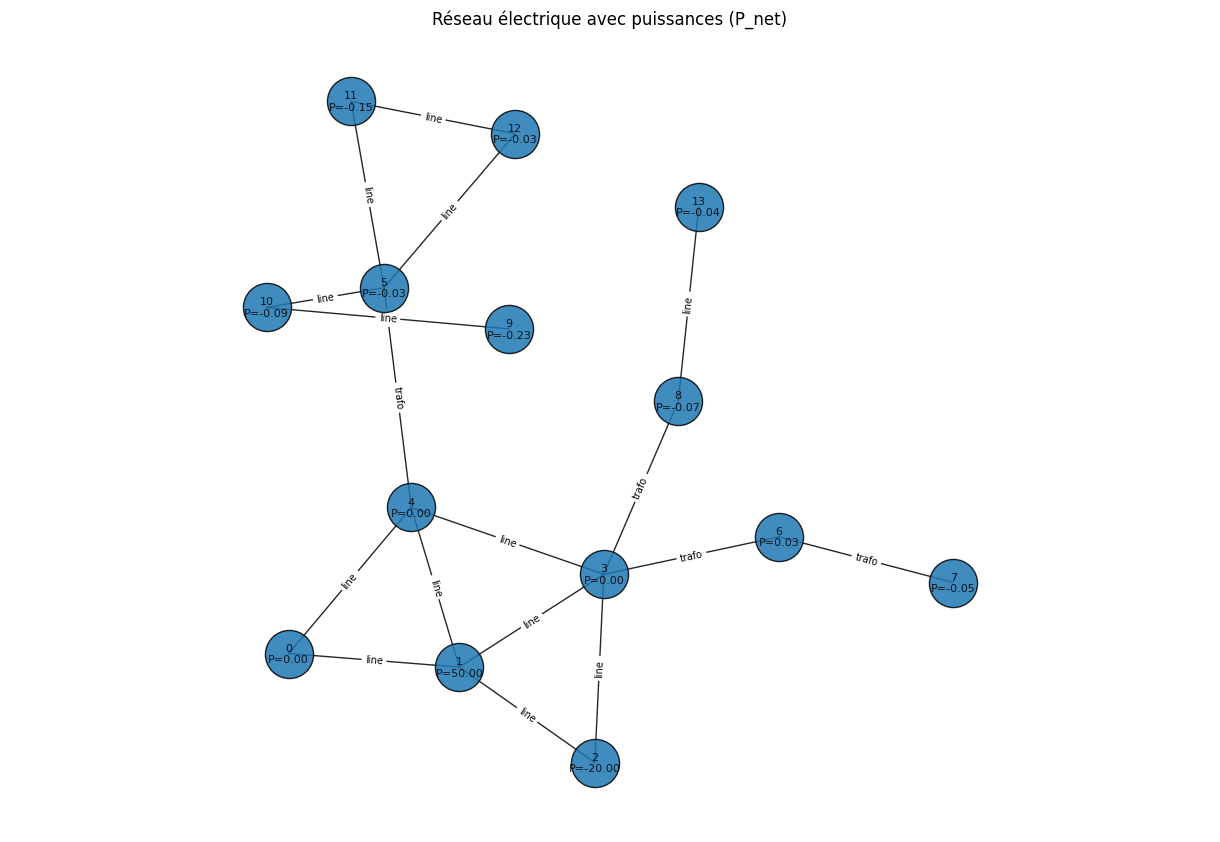

In [580]:
def plot_network(G):
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))

      # Create labels with node index and power demand (P)
      labels = {n: f"{n}\nP={data.get('P', 0):.2f}" for n, data in G.nodes(data=True)}


      nx.draw(
          G, pos,
          with_labels=True, labels=labels, # Use the new labels
          node_size=1200,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique avec puissances (P_net)")
      plt.axis("equal")
      plt.show()

plot_network(G)

In [581]:
#Constant definition
V_min = 0.9
V_max = 1.1


P_min = -0.3
P_max = 0.3

theta_min = -1
theta_max = 1


alpha = 1


In [582]:
m = pyo.ConcreteModel()
# Define base values for the per-unit system
s_base = 100  # MVA
v_base_high = 110 # kV (From the create_network function)

m.Nodes = pyo.Set(initialize= [b for b in G.nodes])
m.Lines = pyo.Set(initialize= [l for l in G.edges])
m.i = pyo.Set(initialize=[0, 1]) # Initialize m.i with two generic elements
m.j = pyo.Set(initialize= [0, 1])
#m.children = pyo.Set(initialize= [1, 2])
m.parents = pyo.Set(initialize = [0])

# Get the line indices from the model
line_indices = list(m.Lines)

# You can print the indices
print("Indices of all lines:")
for line in line_indices:
    print(line)

m.P = pyo.Param(m.Nodes, initialize = {n: - G.nodes[n].get('P_pu') for n in G.nodes}, domain = pyo.Reals, mutable=True) # Make P mutable

m.I_min = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.nodes[i]["vn_kv"])[0] for (i,j) in m.Lines}, domain = pyo.Reals)
m.I_max = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds( G.nodes[i]["vn_kv"])[1] for (i,j) in m.Lines}, domain = pyo.Reals)

print(m.I_min[(0,1)])
print(m.I_max[(0,1)])

# Variables principales
m.F = pyo.Var(m.Lines, m.i, m.j, domain=pyo.Reals)     # active power flow through lines
m.I = pyo.Var(m.Lines,  m.i, m.j, domain=pyo.Reals)  # current flowing through lines
m.theta = pyo.Var(m.Nodes,  m.i, m.j, domain=pyo.Reals)  # phase angle of the voltage
m.V = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)  # voltage magnitude at each node
m.E = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals) #net power injection/consumption
m.P_plus = pyo.Var(m.parents, m.i, m.j, domain=pyo.Reals) #power entering the operational graph
#m.P_minus = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals) #power leaving the operational graph

#m.P_C_set = pyo.Var(m.children, m.i, domain=pyo.Reals) #vertices of the power envelope at each child node

#m.P_C_min = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals)
#m.P_C_max = pyo.Var(m.children, m.i, m.j,  domain=pyo.Reals)

m.V_P = pyo.Param(m.j, initialize = {0: 0.9, 1: 1.1}, domain =pyo.NonNegativeReals)

m.O = pyo.Var(domain= pyo.NonNegativeReals)

for u in G.nodes():
  if G.nodes[u].get('P', 0.0) == 0:
    m.P[u] = 0
  else:
    G.nodes[u]['P_pu'] = G.nodes[u].get('P', 0.0) / s_base
    m.P[u] = - G.nodes[u]['P_pu']

"""# Convert P parameter to per-unit
for n in G.nodes:
    # Assuming P is in MW, convert to per-unit
    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base
    m.P[n] = G.nodes[n]['P']"""

Indices of all lines:
(0, 1)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(3, 4)
(3, 6)
(3, 8)
(4, 5)
(5, 10)
(5, 11)
(5, 12)
(6, 7)
(8, 13)
(9, 10)
(11, 12)
-2.2447378466092647
2.2447378466092647


"# Convert P parameter to per-unit\nfor n in G.nodes:\n    # Assuming P is in MW, convert to per-unit\n    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base\n    m.P[n] = G.nodes[n]['P']"

In [583]:
for n in G.nodes:
  print(m.P[n].value)


0
-0.5
0.2
0
0
0.00025
-0.00025
0.0005
0.0007375
0.0022500000000000003
0.0008750000000000001
0.0015249999999999999
0.0003375
0.0003725


In [584]:
# Auxiliary variable for the absolute value of E (already defined as per-unit)
m.z = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)

m.curt = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals)

def curtailment_def_rule(m,n, vert_pow, vert_volt):

  return m.curt[n, vert_pow, vert_volt] == m.P[n] - m.E[n, vert_pow, vert_volt]

m.curt_def = pyo.Constraint(m.Nodes, m.i, m.j, rule=curtailment_def_rule)
# Constraints to define the absolute value (already defined for per-unit E)
def abs_E_pos_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= m.curt[n, vert_pow, vert_volt]
m.abs_E_pos = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_pos_rule)

def abs_E_neg_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= -m.curt[n, vert_pow, vert_volt]
m.abs_E_neg = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_neg_rule)

def upper_bound_rule(m, vert_pow, vert_volt):
    # m.z is per-unit, m.O is per-unit
    return sum(m.z[n, vert_pow, vert_volt] for n in m.Nodes) <= m.O

m.upper_bound = pyo.Constraint(m.i, m.j, rule=upper_bound_rule)

# Current magnitude constraint (I_min, I_max are assumed per-unit)
def current_bounds_rule(m, i, j, vert_pow, vert_volt):
    # m.I is per-unit current
    return pyo.inequality(m.I_min[(i,j)], m.I[i,j, vert_pow, vert_volt], m.I_max[(i,j)])
m.CurrentBounds = pyo.Constraint(m.Lines, m.i, m.j, rule=current_bounds_rule)

def phase_constr_rule(m,n, vert_pow, vert_volt):
    return pyo.inequality(theta_min, m.theta[n, vert_pow, vert_volt], theta_max)

m.phaseConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=phase_constr_rule)

def dc_power_flow_rule(m, i, j, vert_pow, vert_volt):
    if G[i][j].get('b_pu') is None:
      return pyo.Constraint.Skip
    else:
      return m.F[i, j, vert_pow, vert_volt] == m.V_P[vert_volt]**2 *(G[i][j]['b_pu'] * (
        m.theta[i, vert_pow, vert_volt] - m.theta[j, vert_pow, vert_volt])
    )

m.DCFlow = pyo.Constraint(m.Lines, m.i, m.j, rule=dc_power_flow_rule)


def current_def_rule(m, n, i, j, vert_pow, vert_volt):
    # This constraint relates per-unit current, per-unit voltage, and per-unit power flow.
    # In per-unit, P_pu = V_pu * I_pu. This is correct.
    return np.sqrt(3)* m.I[i,j, vert_pow, vert_volt] * m.V_P[vert_volt] == m.F[i,j, vert_pow, vert_volt]

m.current_def = pyo.Constraint(m.Nodes, m.Lines, m.i, m.j, rule=current_def_rule)



def power_balance_rule(m, n, vert_pow, vert_volt):
    # Compute net flow into node n by summing over all lines (i,j) in m.Lines
    expr = sum(
        (m.F[i, j, vert_pow, vert_volt] if j == n else 0)
      - (m.F[i, j, vert_pow, vert_volt] if i == n else 0)
      for (i, j) in m.Lines
    )
    # If n is a parent node, subtract P_plus; otherwise use only E[n]
    if n in m.parents:
        return expr == m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]
    else:
        return expr == m.E[n, vert_pow, vert_volt]

m.power_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=power_balance_rule)

def parent_power_constraint_rule(m, parent, vert_pow, vert_volt):
    # m.P_plus is per-unit power entering the operational graph
    return pyo.inequality(P_min, m.P_plus[parent, vert_pow, vert_volt], P_max)

m.parent_power_constraint = pyo.Constraint(m.parents, m.i, m.j, rule=parent_power_constraint_rule)

#Constant voltage assumption
def voltage_constr_rule(m, n, vert_pow, vert_volt):
    return m.V[n, vert_pow, vert_volt] == m.V_P[vert_volt]

m.voltageConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=voltage_constr_rule)




"""def test_rule(m):
  return m.O == 0
m.test = pyo.Constraint(rule=test_rule)"""


"""# Auxiliary variables for the L1 norm of P_C_set
m.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)

# Constraints to linearize the L1 norm of P_C_set
def abs_P_C_set_pos_rule(m, n):
    return m.abs_P_C_set[n] >= m.aux[n]
m.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)

def abs_P_C_set_neg_rule(m, n):
    return m.abs_P_C_set[n] >= -m.aux[n]
m.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)"""

'# Auxiliary variables for the L1 norm of P_C_set\nm.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)\n\n# Constraints to linearize the L1 norm of P_C_set\ndef abs_P_C_set_pos_rule(m, n):\n    return m.abs_P_C_set[n] >= m.aux[n]\nm.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)\n\ndef abs_P_C_set_neg_rule(m, n):\n    return m.abs_P_C_set[n] >= -m.aux[n]\nm.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)'

In [585]:
def objective_rule(m):
  return   - alpha*m.O

m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

In [586]:
# Résolution
# -------------------------
# Create an environment with your WLS license
params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
}
env = gp.Env(params=params)
solver = pyo.SolverFactory('gurobi', env= env)

# Solve the model
results = solver.solve(m, tee=True)

# Check the termination condition
if results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print("The model is infeasible.")
elif results.solver.termination_condition == pyo.TerminationCondition.unbounded:
    print("The model is unbounded.")
elif results.solver.termination_condition == pyo.TerminationCondition.infeasibleOrUnbounded:
    print("The model is infeasible or unbounded.")
else:
    print("Solver terminated with condition:", results.solver.termination_condition)
    # Print the results (optional, but good practice)
    print(results)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpzm8neaow.pyomo.lp
Reading time = 0.00 seconds
x1: 1544 rows, 421 columns, 2964 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1544 rows, 421 columns and 2964 nonzeros
Model fingerprint: 0x35678f89
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 2e+00]
Presolve removed 1384 rows and 254 columns
Presolve time: 0.00s
Presolved: 160 rows, 167 columns, 588 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   1.685258e+02

In [587]:
m.O.value

0.0011594000000000008

In [588]:
m.theta[0,0,0].value

-0.9899326869523907

In [589]:
# Print values of m.I
print("Values of m.I:")
for (u, v) in m.Lines:
    for vert_pow in m.i:
        for vert_volt in m.j:
            try:
                print(f"m.I[{u},{v},{vert_pow},{vert_volt}].value: {m.I[u, v, vert_pow, vert_volt].value}")
            except:
                print(f"m.I[{u},{v},{vert_pow},{vert_volt}].value: None")


# Print values of m.I_max
print("\nValues of m.I_max:")
for (u, v) in m.Lines:
  print(m.I_min[(u,v)])


Values of m.I:
m.I[0,1,0,0].value: -0.1707907851130049
m.I[0,1,0,1].value: -0.13973791509245315
m.I[0,1,1,0].value: -0.17079078511299914
m.I[0,1,1,1].value: -0.1397515969647347
m.I[0,4,0,0].value: -0.01817076184034764
m.I[0,4,0,1].value: -0.014866986960281058
m.I[0,4,1,0].value: -0.018170761840342643
m.I[0,4,1,1].value: -0.014853305087998354
m.I[1,2,0,0].value: 0.07747042513201306
m.I[1,2,0,1].value: 0.06338489328982987
m.I[1,2,1,0].value: 0.07747042513201426
m.I[1,2,1,1].value: 0.06337328958689695
m.I[1,3,0,0].value: 0.0376782420752748
m.I[1,3,0,1].value: 0.030827652607045116
m.I[1,3,1,0].value: 0.037678242075276515
m.I[1,3,1,1].value: 0.03080336854181007
m.I[1,4,0,0].value: 0.034810697229499324
m.I[1,4,0,1].value: 0.028481479551410865
m.I[1,4,1,0].value: 0.03481069722950217
m.I[1,4,1,1].value: 0.028503685447297283
m.I[2,3,0,0].value: -0.05082963468790379
m.I[2,3,0,1].value: -0.04158788292646574
m.I[2,3,1,0].value: -0.05082963468790259
m.I[2,3,1,1].value: -0.04159948662939865
m.I[3,4,

Second scenario: envelopes given to DSOs

In [590]:

info_DSO_node1 = sum(m.P[n].value for n in G.subgraph([5, 9, 10, 11,12]).nodes)
info_DSO_node2 = sum(m.P[n].value for n in G.subgraph([6,7,8,13]).nodes)
print(info_DSO_node1)
print(info_DSO_node2)

info_DSO = [info_DSO_node1, info_DSO_node2]

0.0052375
0.00136


In [591]:
"""info_DSO_node1 = m.F[4, 5, 0, 0].value
info_DSO_node2 = m.F[3, 8, 0, 0].value
print(info_DSO_node1)
print(info_DSO_node2)

info_DSO = [info_DSO_node1, info_DSO_node2]"""

'info_DSO_node1 = m.F[4, 5, 0, 0].value\ninfo_DSO_node2 = m.F[3, 8, 0, 0].value\nprint(info_DSO_node1)\nprint(info_DSO_node2)\n\ninfo_DSO = [info_DSO_node1, info_DSO_node2]'

In [592]:
for n in m.Nodes:
    for vert_pow in m.i:
        for vert_volt in m.j:
            print(f"m.theta[{n},{vert_pow},{vert_volt}].value: {m.theta[n,vert_pow,vert_volt].value}")

m.theta[0,0,0].value: -0.9899326869523907
m.theta[0,0,1].value: -0.9932607243235005
m.theta[0,1,0].value: -0.989932686952389
m.theta[0,1,1].value: -0.9932656161726291
m.theta[1,0,0].value: -0.9704842760263067
m.theta[1,0,1].value: -0.9802415401498414
m.theta[1,1,0].value: -0.9704842760263064
m.theta[1,1,1].value: -0.980245157278255
m.theta[2,0,0].value: -1.0
m.theta[2,0,1].value: -1.0
m.theta[2,1,0].value: -1.0
m.theta[2,1,1].value: -1.0
m.theta[3,0,0].value: -0.9832695584858463
m.theta[3,0,1].value: -0.9888002829533353
m.theta[3,1,0].value: -0.9832695584858466
m.theta[3,1,1].value: -0.9887971580481851
m.theta[4,0,0].value: -0.9821330567814958
m.theta[4,0,1].value: -0.9880394842917455
m.theta[4,1,0].value: -0.9821330567814963
m.theta[4,1,1].value: -0.9880491811722811
m.theta[5,0,0].value: -0.9992587291580246
m.theta[5,0,1].value: -0.9993197393884297
m.theta[5,1,0].value: -0.9990512461333334
m.theta[5,1,1].value: -0.9992479381322313
m.theta[6,0,0].value: -1.0
m.theta[6,0,1].value: -1.0


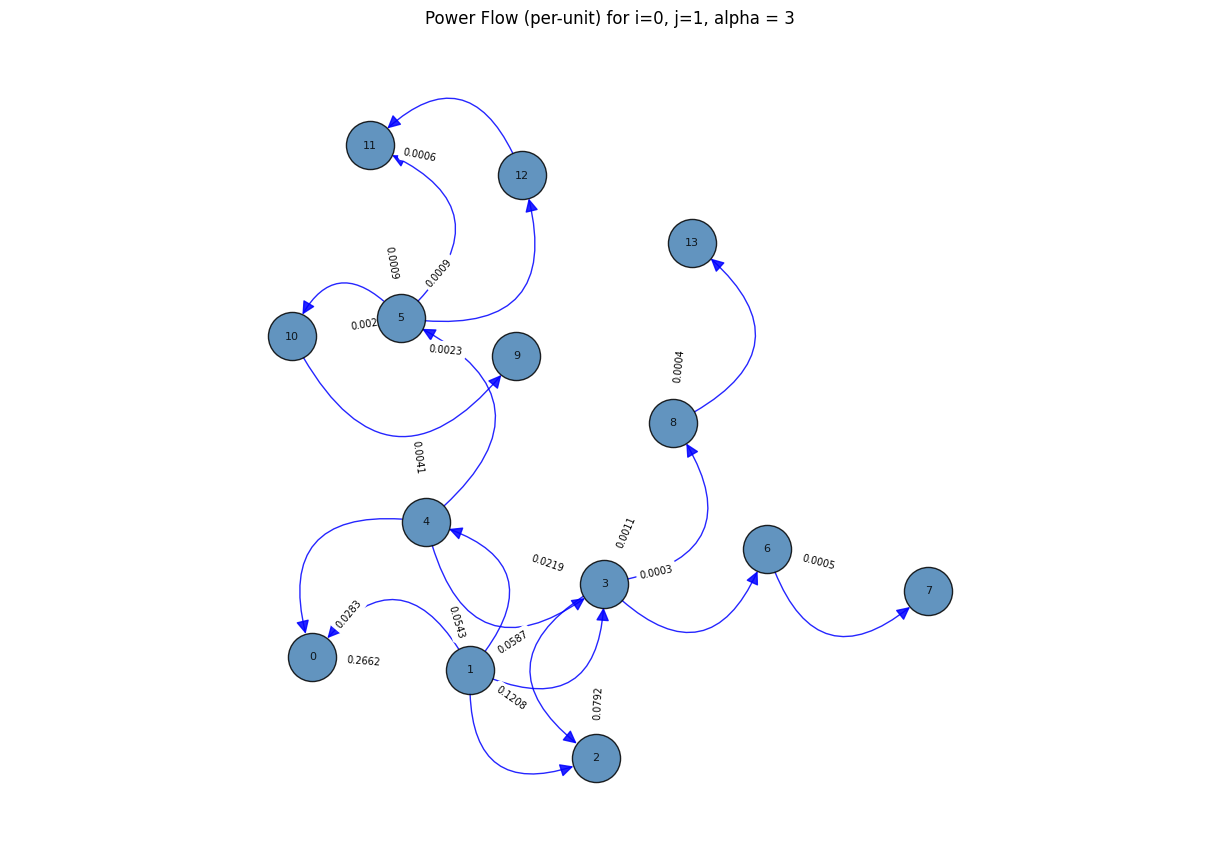

In [593]:
def plot_power_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {n: n for n in G.nodes()}

    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}
    # Create a list of edges with direction based on flow
    directed_edges = []


    for u, v in G.edges():
        try:
            # Get the flow value from the model
            flow_value = m.F[u, v, i, j].value
            if flow_value is not None:
                edge_labels[(u, v)] = f"{round(abs(flow_value), 4)}" # Display absolute value
                if flow_value > 0:
                    edge_colors.append('blue')  # Positive flow (u to v) - Blue arrow
                    directed_edges.append((u, v)) # Arrow from u to v
                elif flow_value < 0:
                    edge_colors.append('blue')  # Negative flow (v to u) - Still blue, but direction will be reversed
                    directed_edges.append((v, u)) # Arrow from v to u (reverse direction)
                else:
                    edge_colors.append('gray') # No flow
                    directed_edges.append((u, v)) # Still add edge for drawing, no specific direction
            else:
                edge_colors.append('gray') # No flow value
                directed_edges.append((u, v)) # Still add edge for drawing, no specific direction
        except Exception as e: # Catching the exception
            print(f"Error processing edge ({u}, {v}): {e}")
            edge_colors.append('gray') # Handle cases where edge might not be in m.F
            directed_edges.append((u, v)) # Still add edge for drawing, no specific direction


    # Create a directed graph for drawing purposes with correct edge directions
    draw_graph = nx.DiGraph()
    draw_graph.add_nodes_from(G.nodes(data=True))
    draw_graph.add_edges_from(directed_edges)

    # Draw the network
    nx.draw(
        draw_graph, pos,
        with_labels=True, labels=labels, # Draw labels with node indices
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors (now always blue or gray for non-zero flow)
        edgecolors="black", font_size=8,
        alpha=0.85,
        node_color='steelblue', # Default node color
        arrows=True, arrowsize=20, # Enable arrows and set size
        connectionstyle='arc3,rad=0.8' # Add some curvature to distinguish directions if needed
    )


    nx.draw_networkx_edge_labels(draw_graph, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3) # Use draw_graph for edge labels

    plt.title(f"Power Flow (per-unit) for i={i}, j={j}, alpha = 3")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_power_flow(m, 0, 1)

In [594]:
import matplotlib.pyplot as plt
import pandas as pd

"""# Extract all values of m.theta
theta_values = []
for n in m.Nodes:
    for vert_pow in m.i:
        for vert_volt in m.j:
            theta_values.append({
                'node': n,
                'i_index': vert_pow,
                'j_index': vert_volt,
                'theta_value': m.theta[n, vert_pow, vert_volt].value
            })

theta_df = pd.DataFrame(theta_values)
print("Extracted m.theta values:")
display(theta_df) # Display the first few rows"""

# Extract all values of m.I
i_values = []
for line in m.Lines:
    u, v = line
    for vert_pow in m.i:
        for vert_volt in m.j:
            i_values.append({
                'from_node': u,
                'to_node': v,
                'i_index': vert_pow,
                'j_index': vert_volt,
                'i_value': m.I[u, v, vert_pow, vert_volt].value
            })

i_df = pd.DataFrame(i_values)
print("\nExtracted m.I values:")
display(i_df) # Display the first few rows


Extracted m.I values:


,from_node,to_node,i_index,j_index,i_value
0,0,1,0,0,-0.170791
1,0,1,0,1,-0.139738
2,0,1,1,0,-0.170791
3,0,1,1,1,-0.139752
4,0,4,0,0,-0.018171
...,...,...,...,...,...
63,9,10,1,1,-0.001181
64,11,12,0,0,-0.000379
65,11,12,0,1,-0.000310
66,11,12,1,0,-0.000379


In [595]:
def create_graph(net) -> nx.Graph:
    import json
    # -------------------------
    # 1. Conversion du réseau Pandapower en DiGraph
    # -------------------------
    G = nx.Graph()

    # 2. Récupération des positions à partir de la colonne 'geo'
    pos = {}
    for idx, row in net.bus.iterrows():
        geo_data = row['geo']
        if geo_data is None:
            raise ValueError(f"Le bus '{row['name']}' (index {idx}) n'a pas de coordonnées 'geo'.")
        geo_dict = json.loads(geo_data)
        coordinates = geo_dict["coordinates"]
        pos[idx] = tuple(coordinates)

    #Ajouter une puissance de base
    G.graph["s_base"] = 100.0 # MVA
    G.graph["v_base"] = 110.0 # kV

    # Ajouter les nœuds
    for idx, row in net.bus.iterrows():
        G.add_node(idx,
                   label=row["name"],
                   pos=pos[idx],
                   vn_kv=row["vn_kv"])

    # Ajouter les arêtes pour les lignes
    for _, row in net.line.iterrows():
        G.add_edge(row["from_bus"], row["to_bus"],
                   type="line",
                   name=row["name"],
                   length=row["length_km"],
                   std_type=row["std_type"],
                   x_ohm=row["x_ohm_per_km"],)

    # Ajouter les arêtes pour les transformateurs
    for _, row in net.trafo.iterrows():
        G.add_edge(row["hv_bus"], row["lv_bus"],
                   type="trafo", std_type = None,
                   name=row["name"])

    # Ajouter les générateurs et les charges comme attributs aux nœuds
    for _, row in net.gen.iterrows():
        G.nodes[row["bus"]]["type"] = "gen"
        G.nodes[row["bus"]]["gen_name"] = row["name"]
        G.nodes[row["bus"]]["gen_power"] = row["p_mw"]

    for _, row in net.load.iterrows():
        G.nodes[row["bus"]]["type"] = "load"
        G.nodes[row["bus"]]["load_name"] = row["name"]
        G.nodes[row["bus"]]["load_power"] = row["p_mw"]

    for _, row in net.ext_grid.iterrows():
        G.nodes[row["bus"]]["type"] = "ext_grid"
        G.nodes[row["bus"]]["grid_name"] = row["name"]

    # -------------------------
    # 2. Define subnetworks and add power attributes to nodes
    # -------------------------
    network1_buses = [0, 1, 2, 3, 4]
    # network2_buses = [3, 7, 5, 9, 10]
    # network3_buses = [4, 8, 6]

    # Assign G1 to G and then add power attributes to nodes in G
    # Revert to the original subgraph definition
    G = G.subgraph(network1_buses)

    # Manually define the 'P' attribute for each node in the subgraph G
    # This replaces the calculation of P_load, P_gen, and P_net from the 'net' object
    # You should define the 'P' value for each node in network1_buses here.
    # Example:

    co = 4
    power_demand = {
        0: 0.0/co,
        1: 50,
        2: -20,
        3: 0/co,
        4: 0/co,
        5: -1e-1/co,
        6: 0.1/co,
        7: -0.2/co,
        8: -29.5*1e-2 /co,
        9: -9.0*1e-1 /co,
        10: -3.5*1e-1 /co,
        11: -6.1*1e-1 /co,
        12: -13.5*1e-2 /co,
        13: -14.9*1e-2 /co
    }


    for n in G.nodes:
        G.nodes[n]["P"] = power_demand.get(n, 0.0)
        G.nodes[n]["P_pu"] = G.nodes[n].get("P", 0.0) / s_base


    print(net.line.columns)

    # Calculate the susceptance and max_current of each line in Siemens
    for u, v, data in G.edges(data=True):
        if data.get('type') == 'trafo':
             # Assign a high max_current for transformers
             data['max_current_pu'] = 1000 # Use a large value
             print(f"Transformer {u}->{v}: max_current_pu = {data['max_current_pu']} pu (high value)")
        else:
            data['b_pu'] = (G.nodes[u]["vn_kv"]**2 / (data['x_ohm'] * G.graph["s_base"]))  # Calcule et stocke B_ij per unit
            print(f"Ligne {u}->{v}: b_pu = {G[u][v]['b_pu']} pu")

            # Calculate max_current for lines based on line type and node voltage
            line_type = data.get('std_type')
            v_node_kv = G.nodes[u].get("vn_kv") # Get voltage of the 'from' node

            if line_type and v_node_kv is not None:
                I_min_pu, I_max_pu = calculate_current_bounds(v_node_kv)
                if I_max_pu is not None:
                    data['max_current_pu'] = I_max_pu
                    print(f"Line {u}->{v}: max_current_pu = {data['max_current_pu']} pu")
                else:
                    print(f"Warning: Could not calculate max_current for line {u}->{v} (unknown line type or voltage).")
                    data['max_current_pu'] = None # Or a default value if appropriate
            else:
                 print(f"Warning: Missing line type or node voltage for line {u}->{v}. Could not calculate max_current.")
                 data['max_current_pu'] = None # Or a default value if appropriate


    B_base = G.graph["s_base"]/(G.graph["v_base"]**2)
    print("B_base: ", B_base)

    # -------------------------
    # Donner accès à G
    # -------------------------
    node_attrs = {n: G.nodes[n] for n in G.nodes}
    return G # Return G and the plot_network function

In [596]:
G = create_graph(net)

Index(['name', 'std_type', 'from_bus', 'to_bus', 'length_km', 'r_ohm_per_km',
       'x_ohm_per_km', 'c_nf_per_km', 'g_us_per_km', 'max_i_ka', 'df',
       'parallel', 'type', 'in_service', 'max_loading_percent', 'geo'],
      dtype='object')
Ligne 0->1: b_pu = 16.900456312320436 pu
Ligne 0->4: b_pu = 4.483500717360115 pu
Ligne 1->2: b_pu = 5.051270394504217 pu
Ligne 1->3: b_pu = 5.671506352087114 pu
Ligne 1->4: b_pu = 5.751092707614446 pu
Ligne 2->3: b_pu = 5.846927439630474 pu
Ligne 3->4: b_pu = 23.747328425552126 pu
B_base:  0.008264462809917356


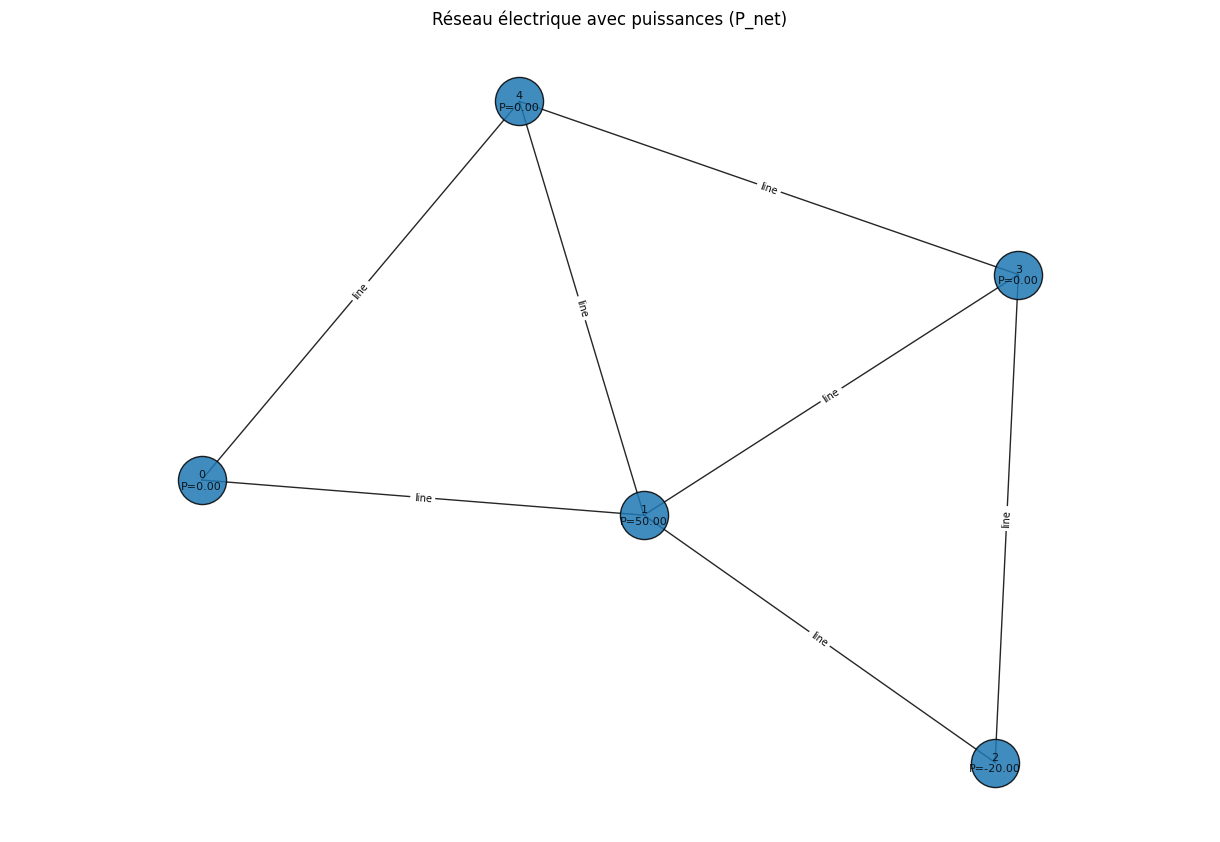

In [597]:
plot_network(G)

In [598]:
m = pyo.ConcreteModel()
# Define base values for the per-unit system
s_base = 100  # MVA
v_base_high = 110 # kV (From the create_network function)
first_child = 3
m.Nodes = pyo.Set(initialize= [b for b in G.nodes])
m.Lines = pyo.Set(initialize= [l for l in G.edges])
m.i = pyo.Set(initialize=[0, 1]) # Initialize m.i with two generic elements
m.j = pyo.Set(initialize= [0, 1])
m.children = pyo.Set(initialize= [first_child, first_child + 1])
m.parents = pyo.Set(initialize = [0])

m.P = pyo.Param(m.Nodes, initialize = {n: - G.nodes[n].get('P_pu') for n in G.nodes}, domain = pyo.Reals, mutable=True) # Make P mutable
m.P_absolute_value = pyo.Param(m.Nodes, initialize = {n: abs(m.P[n]) for n in G.nodes}, domain = pyo.NonNegativeReals) # Make P mutable

m.info_DSO_param = pyo.Param(m.children, initialize = {n: info_DSO[n-1-first_child] for n in m.children}, domain = pyo.Reals) # Renamed parameter and adjusted index for list

m.I_min = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.nodes[i]["vn_kv"])[0] for (i,j) in m.Lines}, domain = pyo.Reals)
m.I_max = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.nodes[i]["vn_kv"])[1] for (i,j) in m.Lines}, domain = pyo.Reals)

print(m.I_min[(0,1)])
print(m.I_max[(0,1)])

# Variables principales
m.F = pyo.Var(m.Lines, m.i, m.j, domain=pyo.Reals)     # active power flow through lines
m.I = pyo.Var(m.Lines,  m.i, m.j, domain=pyo.Reals)  # current flowing through lines
m.theta = pyo.Var(m.Nodes,  m.i, m.j, domain=pyo.Reals)  # phase angle of the voltage
m.V = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)  # voltage magnitude at each node
m.E = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals) #net power injection/consumption
m.P_plus = pyo.Var(m.parents, m.i, m.j, domain=pyo.Reals) #power entering the operational graph
m.P_minus = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals) #power leaving the operational graph

m.P_C_set = pyo.Var(m.children, m.i, domain=pyo.Reals) #vertices of the power envelope at each child node

#m.P_C_min = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals)
#m.P_C_max = pyo.Var(m.children, m.i, m.j,  domain=pyo.Reals)

m.V_P = pyo.Param(m.j, initialize = {0: 0.9, 1: 1.1}, domain =pyo.NonNegativeReals)

m.O = pyo.Var(domain= pyo.NonNegativeReals)
m.tot = pyo.Var(domain= pyo.Reals)
m.aux = pyo.Var(m.children, domain=pyo.Reals)
m.diff_DSO = pyo.Var(m.children, domain=pyo.NonNegativeReals)

for u in G.nodes():
  if G.nodes[u].get('P', 0.0) / s_base == 0:
    m.P[u] = 0
  else:
    G.nodes[u]['P_pu'] = G.nodes[u].get('P', 0.0) / s_base
    m.P[u] = - G.nodes[u]['P_pu']

"""# Convert P parameter to per-unit
for n in G.nodes:
    # Assuming P is in MW, convert to per-unit
    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base
    m.P[n] = G.nodes[n]['P']"""

-2.2447378466092647
2.2447378466092647


"# Convert P parameter to per-unit\nfor n in G.nodes:\n    # Assuming P is in MW, convert to per-unit\n    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base\n    m.P[n] = G.nodes[n]['P']"

In [599]:
for n in G.nodes:
  print(m.P[n].value)
m.P[1].value


0
-0.5
0.2
0
0


-0.5

In [600]:
for u, v, data in G.edges(data=True):
    if 'b_pu' in data:
        print(f"Line ({u}, {v}): b_pu = {data['b_pu']} pu")
    else:
        print(f"Line ({u}, {v}): b_pu not available")

Line (0, 1): b_pu = 16.900456312320436 pu
Line (0, 4): b_pu = 4.483500717360115 pu
Line (1, 2): b_pu = 5.051270394504217 pu
Line (1, 3): b_pu = 5.671506352087114 pu
Line (1, 4): b_pu = 5.751092707614446 pu
Line (2, 3): b_pu = 5.846927439630474 pu
Line (3, 4): b_pu = 23.747328425552126 pu


In [601]:
#Children nodes consumption
def worst_case_children(m, n, vert_pow, vert_volt):
  return m.P_C_set[n, vert_pow] == m.P_minus[n, vert_pow, vert_volt]
m.worst_case = pyo.Constraint(m.children, m.i, m.j, rule=worst_case_children)


# Auxiliary variable for the absolute value of E (already defined as per-unit)
m.z = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)

m.curt = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals)

def curtailment_def_rule(m,n, vert_pow, vert_volt):

  return m.curt[n, vert_pow, vert_volt] == m.P[n] - m.E[n, vert_pow, vert_volt]

m.curt_def = pyo.Constraint(m.Nodes, m.i, m.j, rule=curtailment_def_rule)
# Constraints to define the absolute value (already defined for per-unit E)
def abs_E_pos_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= m.curt[n, vert_pow, vert_volt]
m.abs_E_pos = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_pos_rule)

def abs_E_neg_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= -m.curt[n, vert_pow, vert_volt]
m.abs_E_neg = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_neg_rule)

def upper_bound_rule(m, vert_pow, vert_volt):
    # m.z is per-unit, m.O is per-unit
    return sum(m.z[n, vert_pow, vert_volt] for n in m.Nodes) <= m.O

m.upper_bound = pyo.Constraint(m.i, m.j, rule=upper_bound_rule)

# Current magnitude constraint (I_min, I_max are assumed per-unit)
def current_bounds_rule(m, i, j, vert_pow, vert_volt):
    # m.I is per-unit current
    return pyo.inequality(m.I_min[(i,j)], m.I[i,j, vert_pow, vert_volt], m.I_max[(i,j)])
m.CurrentBounds = pyo.Constraint(m.Lines, m.i, m.j, rule=current_bounds_rule)

def phase_constr_rule(m,n, vert_pow, vert_volt):
    return pyo.inequality(theta_min, m.theta[n, vert_pow, vert_volt], theta_max)

m.phaseConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=phase_constr_rule)

def dc_power_flow_rule(m, i, j, vert_pow, vert_volt):
    if G[i][j].get('b_pu') is None:
      return pyo.Constraint.Skip
    else:
      return m.F[i, j, vert_pow, vert_volt] == m.V_P[vert_volt]**2 *(G[i][j]['b_pu'] * (
        m.theta[i, vert_pow, vert_volt] - m.theta[j, vert_pow, vert_volt])
    )

m.DCFlow = pyo.Constraint(m.Lines, m.i, m.j, rule=dc_power_flow_rule)

def current_def_rule(m, n, i, j, vert_pow, vert_volt):
    # This constraint relates per-unit current, per-unit voltage, and per-unit power flow.
    # In per-unit, P_pu = V_pu * I_pu. This is correct.
    return np.sqrt(3)* m.I[i,j, vert_pow, vert_volt] * m.V_P[vert_volt] == m.F[i,j, vert_pow, vert_volt]

m.current_def = pyo.Constraint(m.Nodes, m.Lines, m.i, m.j, rule=current_def_rule)



"""def nodes_balance(m, n, vert_pow, vert_volt):
    inflow = sum(m.F[k, n, vert_pow, vert_volt] for k in G.predecessors(n) if (k, n) in m.Lines)
    outflow = sum(m.F[n, j, vert_pow, vert_volt] for j in G.successors(n) if (n, j) in m.Lines)
    if n in m.parents:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]

    if n in m.children:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] + m.P_minus[n, vert_pow, vert_volt]

    else:
      return inflow - outflow ==  m.E[n,vert_pow,vert_volt]

m.nodes_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=nodes_balance)"""

def power_balance_rule(m, n, vert_pow, vert_volt):
    # Compute net flow into node n by summing over all lines (i,j) in m.Lines
    expr = sum(
        (m.F[i, j, vert_pow, vert_volt] if j == n else 0)
      - (m.F[i, j, vert_pow, vert_volt] if i == n else 0)
      for (i, j) in m.Lines
    )
    # If n is a parent node, subtract P_plus; otherwise use only E[n]
    if n in m.parents:
      return expr == m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]

    if n in m.children:
      return expr ==  m.E[n, vert_pow, vert_volt] + m.P_minus[n, vert_pow, vert_volt]
    else:
      return expr == m.E[n, vert_pow, vert_volt]

m.power_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=power_balance_rule)

def parent_power_constraint_rule(m, parent, vert_pow, vert_volt):
    # m.P_plus is per-unit power entering the operational graph
    return pyo.inequality(P_min/2, m.P_plus[parent, vert_pow, vert_volt],P_max/2)

m.parent_power_constraint = pyo.Constraint(m.parents, m.i, m.j, rule=parent_power_constraint_rule)


#Constant voltage assumption
def voltage_constr_rule(m, n, vert_pow, vert_volt):
    return m.V[n, vert_pow, vert_volt] == m.V_P[vert_volt]

m.voltageConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=voltage_constr_rule)

def children_voltage_rule(m, children, vert_pow, vert_volt):
    return pyo.inequality(V_min, m.V[children, vert_pow, vert_volt], V_max)

m.children_voltage = pyo.Constraint(m.children, m.i, m.j, rule=children_voltage_rule)



def aux_constraint_rule(m, n):
  return m.aux[n] == m.P_C_set[n, 0] - m.P_C_set[n, 1]
m.aux_constraint = pyo.Constraint(m.children, rule=aux_constraint_rule)

def logical_constraint_rule(m, n):
  return m.P_C_set[n, 0] >= m.P_C_set[n, 1]
m.logical_constraint = pyo.Constraint(m.children, rule=logical_constraint_rule)

"""def info_DSO_min_rule(m,n):
  return m.P_C_set[n,1] <= m.info_DSO_param[n]
m.info_DSO_min = pyo.Constraint(m.children, rule=info_DSO_min_rule)

def info_DSO_max_rule(m,n):
  return m.P_C_set[n,0] >= m.info_DSO_param[n]
m.info_DSO_max = pyo.Constraint(m.children, rule=info_DSO_max_rule)"""

def tot_rule(m):
  return m.tot == sum(m.aux[n] for n in m.children)
m.tot_constraint = pyo.Constraint(rule=tot_rule)

def diff_DSO_rule(m,n):
  return - m.diff_DSO[n] <= (m.P_C_set[n,0] + m.P_C_set[n,1])/2 - m.info_DSO_param[n]
m.diff_DSO_constraint = pyo.Constraint(m.children, rule=diff_DSO_rule)

def diff_bis_dso_rule(m,n):
  return (m.P_C_set[n,0] + m.P_C_set[n,1])/2 - m.info_DSO_param[n] <= m.diff_DSO[n]
m.diff_bis_dso_constraint = pyo.Constraint(m.children, rule=diff_bis_dso_rule)


m.abs_diff_DSO = pyo.Var(m.children, domain=pyo.NonNegativeReals)
"""def abs_different_rule(m, n):
    return  m.abs_diff_DSO[n] >= -m.diff_DSO[n]
m.abs_different = pyo.Constraint(m.children, rule=abs_different_rule)

def abs_different_bis_rule(m, n):
    return  m.abs_diff_DSO[n] >= m.diff_DSO[n]
m.abs_different = pyo.Constraint(m.children, rule=abs_different_rule)"""

m.tot_bis = pyo.Var(domain=pyo.Reals)
def tot_bis_rule(m):
  return m.tot_bis == sum(m.diff_DSO[n] for n in m.children)
m.tot_bis_constraint = pyo.Constraint(rule=tot_bis_rule)

# Build sets based on sign of parameter P
m.PositiveNodes = pyo.Set(initialize=[n for n in m.Nodes if pyo.value(m.P[n]) >= 0])
m.NegativeNodes = pyo.Set(initialize=[n for n in m.Nodes if pyo.value(m.P[n]) <= 0])

# Constraint for positive P: upper bound
def net_power_upper_rule(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] <= m.P[n]
m.net_power_upper = pyo.Constraint(m.PositiveNodes, m.i, m.j, rule=net_power_upper_rule)

def sign_E_rule(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] >= 0

m.sign_E = pyo.Constraint(m.PositiveNodes, m.i, m.j, rule=sign_E_rule)



# Constraint for negative P: lower bound
def net_power_lower_rule(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] >= m.P[n]
m.net_power_lower = pyo.Constraint(m.NegativeNodes, m.i, m.j, rule=net_power_lower_rule)

def sign_E_lower_rule(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] <= 0

m.sign_E_lower = pyo.Constraint(m.NegativeNodes, m.i, m.j, rule=sign_E_lower_rule)

"""m.PositiveNodes = pyo.Set(initialize=[n for n in m.Nodes if m.P[n] >= 0])
m.NegativeNodes = pyo.Set(initialize=[n for n in m.Nodes if m.P[n] <= 0])

# Constraint for positive P: upper bound
def net_power_upper(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] <= m.P[n]
m.net_power_upper = pyo.Constraint(m.PositiveNodes, m.i, m.j, rule=net_power_upper)

# Constraint for negative P: lower bound
def net_power_lower(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] >= m.P[n]
m.net_power_lower = pyo.Constraint(m.NegativeNodes, m.i, m.j, rule=net_power_lower)"""

"""# Auxiliary variables for the L1 norm of P_C_set
m.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)

# Constraints to linearize the L1 norm of P_C_set
def abs_P_C_set_pos_rule(m, n):
    return m.abs_P_C_set[n] >= m.aux[n]
m.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)

def abs_P_C_set_neg_rule(m, n):
    return m.abs_P_C_set[n] >= -m.aux[n]
m.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)"""

'# Auxiliary variables for the L1 norm of P_C_set\nm.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)\n\n# Constraints to linearize the L1 norm of P_C_set\ndef abs_P_C_set_pos_rule(m, n):\n    return m.abs_P_C_set[n] >= m.aux[n]\nm.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)\n\ndef abs_P_C_set_neg_rule(m, n):\n    return m.abs_P_C_set[n] >= -m.aux[n]\nm.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)'

In [602]:
A = [0.5,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,2,2.05,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2]
#A = range(-3, 26)
beta = 1
enveloppe_taille = []
curtail = []
close = []

somme_contributions = []
for alpha in A:
  val = 0
  print(alpha)
  print(m.P_C_set[first_child,0].value)
  print(m.P_C_set[first_child,1].value)

  print(m.P_C_set[first_child + 1,0].value)
  print(m.P_C_set[first_child +1,1].value)
  def objective_rule(m):
    return  m.tot - alpha*m.O - beta * m.tot_bis
  m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
  params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
           }
  env = gp.Env(params=params)
  solver = pyo.SolverFactory('gurobi', env= env)
  results = solver.solve(m, tee=True)

  # Check the termination condition before accessing results
  if results.solver.termination_condition == pyo.TerminationCondition.optimal:
      val = sum(abs(m.P_C_set[n,0].value) + abs(m.P_C_set[n,1].value) for n in m.children)
      # Append optimal results to lists
      curtail.append(m.O.value)
      enveloppe_taille.append(m.tot.value)
      close.append(m.tot_bis.value)
      somme_contributions.append(m.tot.value + m.tot_bis.value)

  else:
      # Append None for non-optimal results to maintain list length
      curtail.append(None)
      enveloppe_taille.append(None)
      close.append(None)
      somme_contributions.append(None)

0.5
None
None
None
None
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpwmwcyiv1.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x674f2caf
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [5e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1487562e+

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1
0.00136
0.00136
0.6486400000000003
-0.35136000000000167
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpgvtd53dt.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xb5493418
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



0.00136
0.00136
0.6486400000000003
-0.35136000000000167
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpbatnjwi9.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xe95dfbb3
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf. 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.2
0.00136
0.00136
0.6486400000000003
-0.35136000000000167
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp9o4z1k7g.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x93da4a0d
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual In

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.3
0.00136
0.00136
0.6486400000000003
-0.35136000000000167
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpdxjxeo5u.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x24f2a393
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual In

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.4
0.00136
0.00136
0.6486400000000003
-0.35136000000000167
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp86qhvhh6.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x40d2548d
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.01s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual In

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



0.00136
0.00136
0.6486400000000003
-0.35136000000000167
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpxccshb4w.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xd12e16d4
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf. 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



0.00136
0.00136
0.6486400000000021
-0.35135999999999923
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp0xsu74wg.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x75ae4a12
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf. 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.7
0.00136
0.00136
0.6486400000000021
-0.051359999999994646
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp6epzl3vo.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x1e09a76e
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual I

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.8
0.00136
0.00136
0.6486400000000021
-0.051359999999994646
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmppup__73m.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xe644c7ec
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual I

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.9
0.00136
0.00136
0.6486400000000021
-0.051359999999994646
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp7aavunqo.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x5faa7f7a
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual I

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.95
0.00136
0.00136
0.6486400000000021
-0.051359999999994646
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpu568k9zn.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xe6996a48
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2
0.00136
0.00136
0.6486400000000021
-0.051359999999994646
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpl5u7qwcd.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x1d04860c
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.05
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpd7ts_74d.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x683d2b88
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Tim

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.1
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpar4yy2zv.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xf5c4a930
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.2
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpmuiwf31_.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xabca94e0
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.3
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp6lbuh01q.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x33becd8b
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.4
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpqv68hnma.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x8aec5d5b
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.5
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmphv2y10xj.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xf83c4e9b
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.6
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpt6u7_is2.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x207664c2
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.7
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpifchg31k.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x44fa6e89
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpfdhyumzw.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xe6102ed2
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.9
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp7yrx5ck3.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x0b80e067
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


3
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp0sx95h9n.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x7366883c
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


3.1
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpvoc50iu2.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xa4de49d4
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


3.2
0.00136
0.00136
0.44864000000000226
0.14864
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpzu4zflz3.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x509d9032
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

In [603]:
print(enveloppe_taille)
print(curtail)
print(close)
print(somme_contributions)

[1.000000000000002, 1.000000000000002, 1.000000000000002, 1.000000000000002, 1.000000000000002, 1.000000000000002, 1.0000000000000013, 0.6999999999999967, 0.6999999999999967, 0.6999999999999967, 0.6999999999999967, 0.6999999999999967, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226, 0.30000000000000226]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.14340249999999932, 0.14340249999999932, 0.14340249999999932, 0.14340249999999932, 0.14340249999999932, 0.14340249999999932, 0.14340250000000143, 0.29340250000000373, 0.29340250000000373, 0.29340250000000373, 0.29340250000000373, 0.29340250000000373, 0.2934025000000011, 0.2934025000000011, 0.2934025000000011, 0.2934025000000011, 0.29340

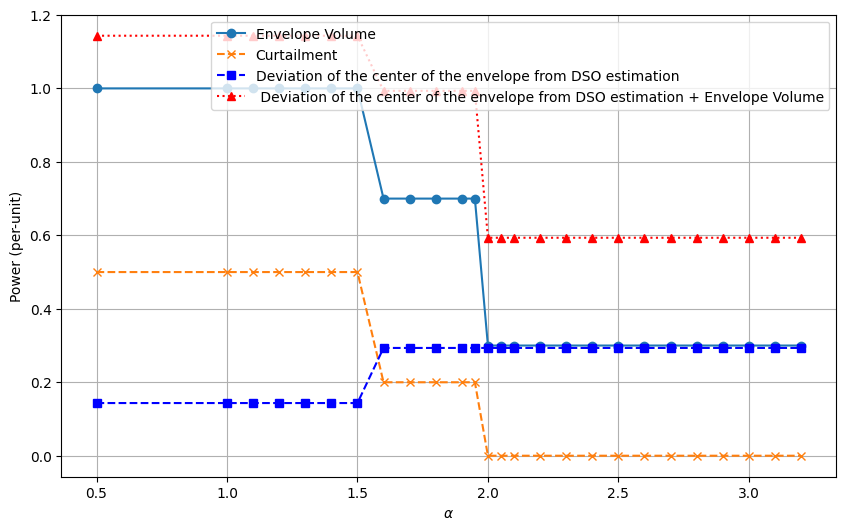

In [604]:
# Convert A to a numpy array for easier plotting
alpha_values = np.array(A)

# Convert lists to numpy arrays, replacing None with NaN for plotting
enveloppe_taille_np = np.array(enveloppe_taille, dtype=float)
curtail_np = np.array(curtail, dtype=float)
close_np = np.array(close, dtype=float)


plt.figure(figsize=(10, 6))

# Plot enveloppe_taille vs alpha
plt.plot(alpha_values, enveloppe_taille_np, marker='o', linestyle='-', label='Envelope Volume')

# Plot curtail vs alpha
plt.plot(alpha_values, curtail_np, marker='x', linestyle='--', label='Curtailment')

# Plot close vs alpha
plt.plot(alpha_values, close_np, marker='s', linestyle='--', color='blue', label='Deviation of the center of the envelope from DSO estimation')

plt.plot(alpha_values, somme_contributions, marker='^', linestyle=':', color='red', label=' Deviation of the center of the envelope from DSO estimation + Envelope Volume')

# Set x-axis to a logarithmic scale
#plt.xscale('log')

plt.xlabel('$\\alpha$')
plt.ylabel('Power (per-unit)')
#plt.title(f'Evolution of the volume of the envelope, curtailment and closeness to DSO estimation as a function of parameter Alpha (beta={beta})')
plt.legend()
plt.grid(True)

# Save the plot as a PDF file
plt.savefig('DOE_alloc_alpha.pdf')

plt.show()

m.E[0,0,0].value: 0.0
m.E[0,0,1].value: 0.0
m.E[0,1,0].value: 0.0
m.E[0,1,1].value: 0.0
m.E[1,0,0].value: -0.5
m.E[1,0,1].value: -0.5
m.E[1,1,0].value: -0.5
m.E[1,1,1].value: -0.5
m.E[2,0,0].value: 0.2
m.E[2,0,1].value: 0.2
m.E[2,1,0].value: 0.2
m.E[2,1,1].value: 0.2
m.E[3,0,0].value: 0.0
m.E[3,0,1].value: 0.0
m.E[3,1,0].value: 0.0
m.E[3,1,1].value: 0.0
m.E[4,0,0].value: 0.0
m.E[4,0,1].value: 0.0
m.E[4,1,0].value: 0.0
m.E[4,1,1].value: 0.0


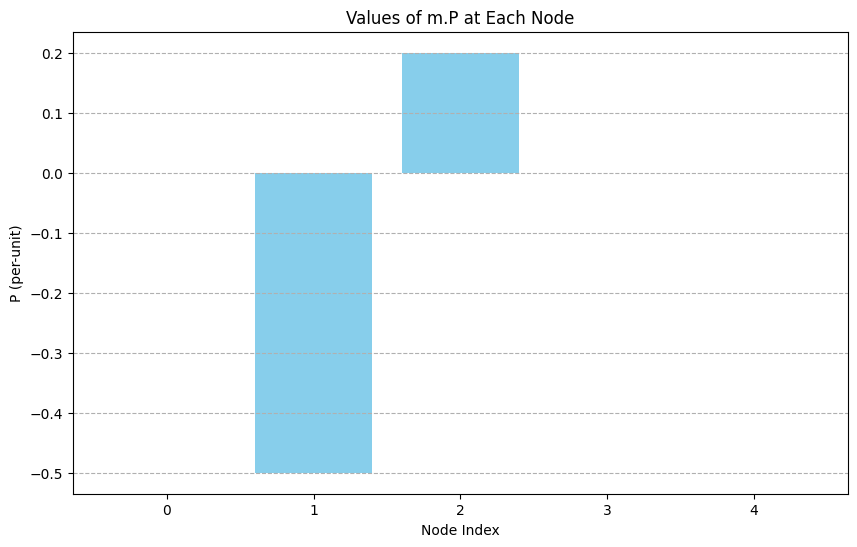

In [605]:
import matplotlib.pyplot as plt
import numpy as np

# Print the values of m.E
for n in m.Nodes:
  for vert_pow in m.i:
    for vert_volt in m.j:
      print(f"m.E[{n},{vert_pow},{vert_volt}].value: {m.E[n,vert_pow,vert_volt].value}")

# Get the values of m.P for plotting
p_values = [m.P[n].value for n in m.Nodes]
node_indices = list(m.Nodes)

# Create a bar plot of m.P values
plt.figure(figsize=(10, 6))
plt.bar(node_indices, p_values, color='skyblue')
plt.xlabel('Node Index')
plt.ylabel('P (per-unit)')
plt.title('Values of m.P at Each Node')
plt.xticks(node_indices) # Ensure all node indices are shown on the x-axis
plt.grid(axis='y', linestyle='--')
plt.show()

In [606]:
m.O.value

0.0

In [607]:
print(m.P_C_set[first_child,0].value)
print(m.P_C_set[first_child,1].value)

print(m.P_C_set[first_child + 1,0].value)
print(m.P_C_set[first_child + 1,1].value)

0.00136
0.00136
0.44864000000000226
0.14864


In [608]:
print(m.theta[0,0,0].value)
print(m.theta[0,0,1].value)

-0.9590333119583565
-0.9725760187489823


In [609]:

m.O.value


0.0

In [610]:
for (u,v) in m.Lines:
  print((u,v))

(0, 1)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(3, 4)


In [611]:
# Corrected loop structure to iterate over m.Lines
for (u, v) in m.Lines:
  for vert_pow in m.i:
    for vert_volt in m.j:
      print(f"Flow on line ({u}, {v}) for i={vert_pow}, j={vert_volt}: {m.F[u, v, vert_pow, vert_volt].value}")

Flow on line (0, 1) for i=0, j=0: 0.00473885752247466
Flow on line (0, 1) for i=0, j=1: 0.004738857522474734
Flow on line (0, 1) for i=1, j=0: -0.17812117371821648
Flow on line (0, 1) for i=1, j=1: -0.17812117371822112
Flow on line (0, 4) for i=0, j=0: 0.14526114247752364
Flow on line (0, 4) for i=0, j=1: 0.14526114247752525
Flow on line (0, 4) for i=1, j=0: 0.028121173718216486
Flow on line (0, 4) for i=1, j=1: 0.02812117371822112
Flow on line (1, 2) for i=0, j=0: 0.16620002583283588
Flow on line (1, 2) for i=0, j=1: 0.1662000258328358
Flow on line (1, 2) for i=1, j=0: 0.1355391091001016
Flow on line (1, 2) for i=1, j=1: 0.13553910910010192
Flow on line (1, 3) for i=0, j=0: 0.1538215150426288
Flow on line (1, 3) for i=0, j=1: 0.15382151504262948
Flow on line (1, 3) for i=1, j=0: 0.08965478254274817
Flow on line (1, 3) for i=1, j=1: 0.08965478254274917
Flow on line (1, 4) for i=0, j=0: 0.18471731664700997
Flow on line (1, 4) for i=0, j=1: 0.18471731664701174
Flow on line (1, 4) for i=1

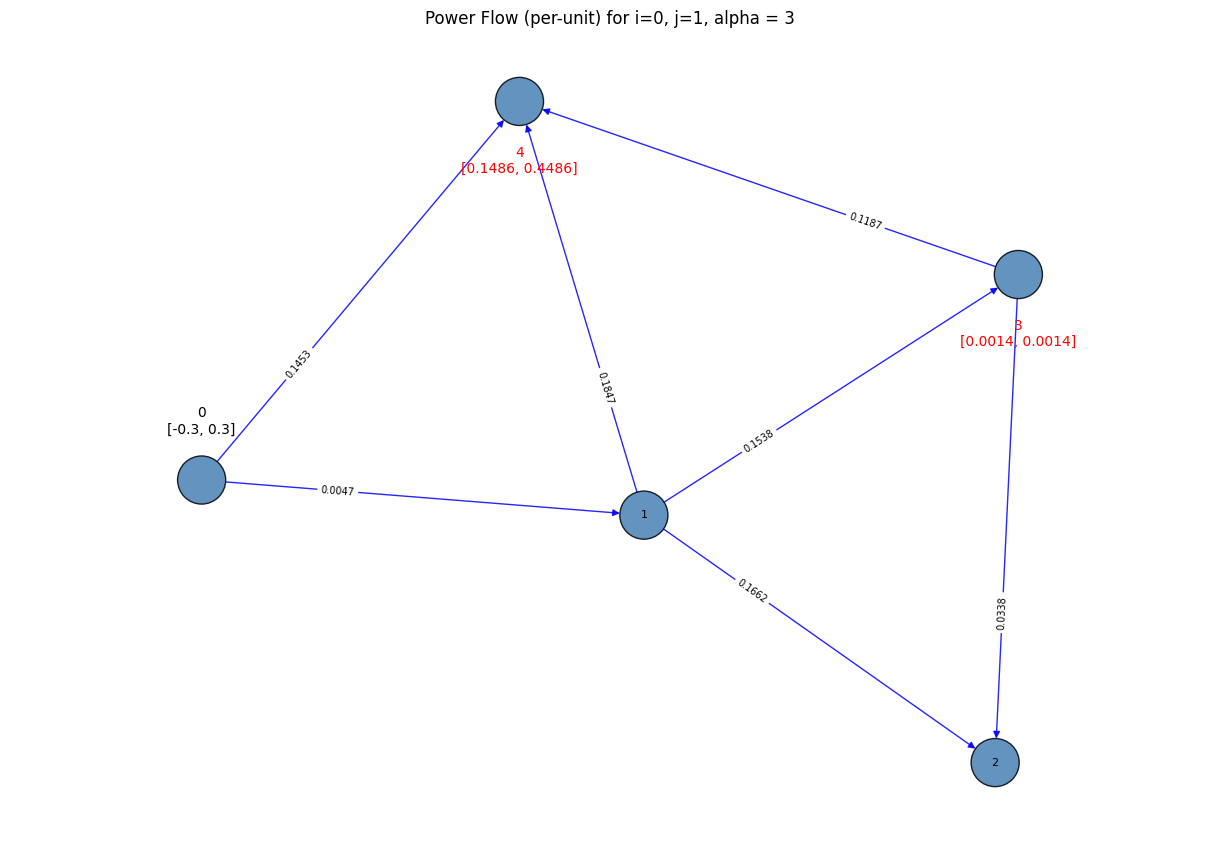

In [612]:
def plot_power_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {}
    label_colors = [] # This is for node colors, will remove this later if needed or set to default
    # Use the defined children and parents sets from the model
    children_nodes_set = m.children
    parents_nodes_set = m.parents

    for n in G.nodes():
        label_text = f"{n}"
        if n in parents_nodes_set:
            # Display parent bounds using the global P_min and P_max parameters
            label_text += f"\n[{P_min}, {P_max}]"
            # No specific color for label text here, use default
            label_colors.append('steelblue') # Default node color based on previous plots
        elif n in children_nodes_set:
            # Display children interval with smaller value first
            # Access P_C_set values - assuming P_C_set is defined and indexed by children and i
            p_c_values = [m.P_C_set[n, 0].value, m.P_C_set[n, 1].value] # Assuming m.P_C_set is indexed by children and i
            label_text += f"\n[{round(min(p_c_values), 4)}, {round(max(p_c_values), 4)}]"
            # We will try to color this text red when drawing labels
            label_colors.append('steelblue') # Default node color
        else:
            label_colors.append('steelblue') # Default node color
        labels[n] = label_text


    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}
    # Create a list of edges with direction based on flow
    directed_edges = []


    for u, v in G.edges():
        try:
            # Get the flow value from the model
            flow_value = m.F[u, v, i, j].value
            if flow_value is not None:
                edge_labels[(u, v)] = f"{round(abs(flow_value), 4)}" # Display absolute value
                if flow_value > 0:
                    edge_colors.append('blue')  # Positive flow (u to v) - Blue arrow
                    directed_edges.append((u, v)) # Arrow from u to v
                elif flow_value < 0:
                    edge_colors.append('blue')  # Negative flow (v to u) - Still blue, but direction will be reversed
                    directed_edges.append((v, u)) # Arrow from v to u (reverse direction)
                else:
                    edge_colors.append('gray') # No flow
                    directed_edges.append((u, v)) # Still add edge for drawing, no specific direction
            else:
                edge_colors.append('gray') # No flow value
                directed_edges.append((u, v)) # Still add edge for drawing, no specific direction
        except Exception as e: # Catching the exception
            print(f"Error processing edge ({u}, {v}): {e}")
            edge_colors.append('gray') # Handle cases where edge might not be in m.F
            directed_edges.append((u, v)) # Still add edge for drawing, no specific direction


    # Create a directed graph for drawing purposes with correct edge directions
    draw_graph = nx.DiGraph()
    draw_graph.add_nodes_from(G.nodes(data=True))
    draw_graph.add_edges_from(directed_edges)

    # Draw the network
    nx.draw(
        draw_graph, pos,
        with_labels=False, # Draw labels separately for color control
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors (now always blue or gray for non-zero flow)
        edgecolors="black", font_size=8,
        alpha=0.85,
        node_color = label_colors # Apply node colors
    )

    # Draw labels with different colors
    for n in G.nodes():
        x, y = pos[n]
        text = labels[n]
        if n in children_nodes_set:
            plt.text(x, y - 0.1, text, fontsize=10, ha='center', va='top', color='red') # Color children interval red
        elif n in parents_nodes_set:
             plt.text(x, y + 0.1, text, fontsize=10, ha='center', va='bottom', color='black') # Color parent bounds black
        else:
             plt.text(x, y, text, fontsize=8, ha='center', va='center', color='black') # Default color for other labels


    nx.draw_networkx_edge_labels(draw_graph, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3) # Use draw_graph for edge labels

    plt.title(f"Power Flow (per-unit) for i={i}, j={j}, alpha = 3")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_power_flow(m, 0, 1)

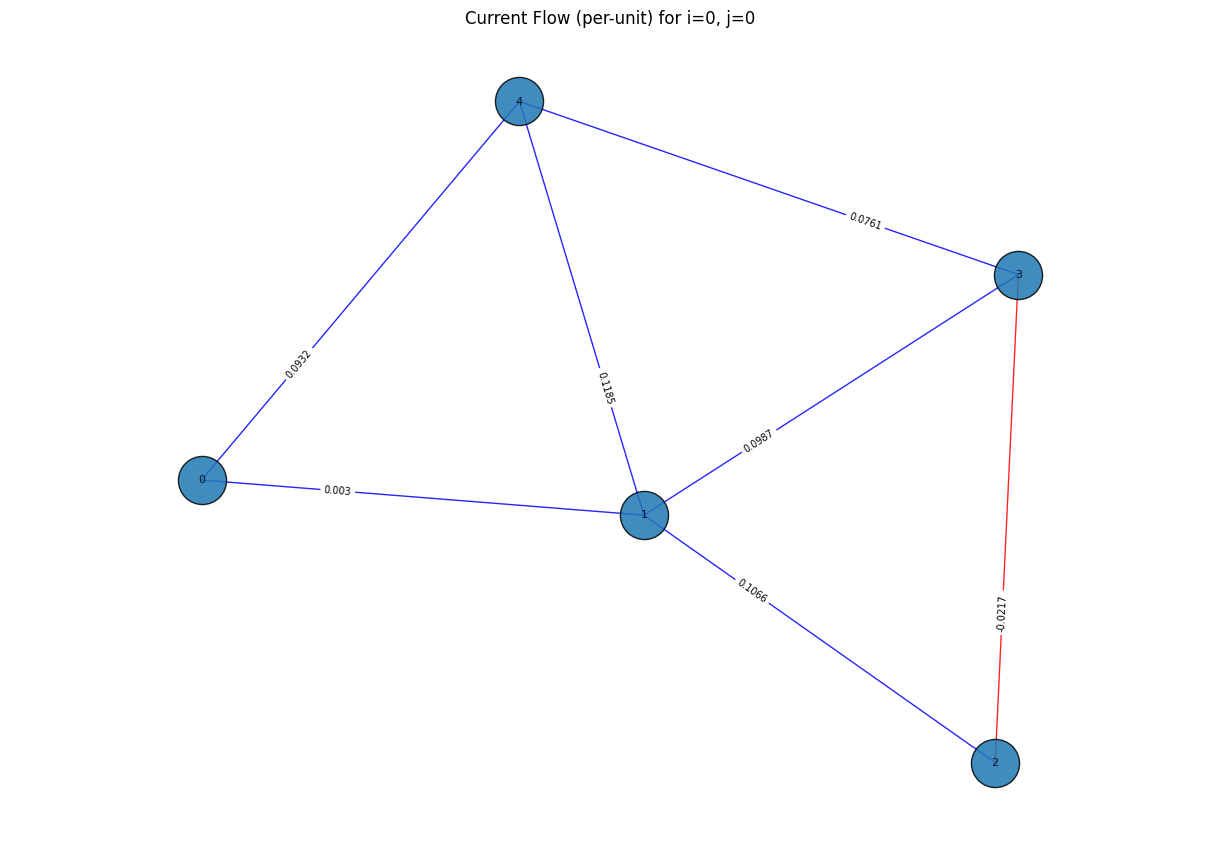

In [613]:
def plot_current_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {n: n for n in G.nodes()}

    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}

    for u, v in G.edges():
        try:
            # Get the current value from the model
            current_value = m.I[u, v, i, j].value
            if current_value is not None:
                edge_labels[(u, v)] = f"{round(current_value, 4)}"
                if current_value > 0:
                    edge_colors.append('blue')  # Positive current flow
                elif current_value < 0:
                    edge_colors.append('red')  # Negative current flow
                else:
                    edge_colors.append('gray') # No current flow
            else:
                edge_colors.append('gray') # No current value
        except:
            edge_colors.append('gray') # Handle cases where edge might not be in m.I

    nx.draw(
        G, pos,
        with_labels=True, labels=labels, # Set with_labels to True and pass node indices as labels
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors
        edgecolors="black", font_size=8,
        alpha=0.85
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3)

    plt.title(f"Current Flow (per-unit) for i={i}, j={j}")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_current_flow(m, 0, 0)

In [614]:
B = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,2,2.05,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3]
#A = range(-3, 26)
alpha = 1.5
enveloppe_taille = []
curtail = []
close = []
somme_contributions = []

for beta in B:
  print(alpha)
  def objective_rule(m):
    return  m.tot - alpha*m.O - beta * m.tot_bis
  m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
  params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
           }
  env = gp.Env(params=params)
  solver = pyo.SolverFactory('gurobi', env= env)
  results = solver.solve(m, tee=True)

  # Check the termination condition before accessing results
  if results.solver.termination_condition == pyo.TerminationCondition.optimal:
      curtail.append(m.O.value)
      enveloppe_taille.append(m.tot.value)
      close.append(m.tot_bis.value)
      somme_contributions.append(m.O.value + m.tot.value)

  else:
      # Append None for non-optimal results to maintain list length
      curtail.append(None)
      enveloppe_taille.append(None)
      close.append(None)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp74pdotw_.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xebd07291
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [5e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9740581e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpx84dmijq.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xb62a65bb
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [6e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0089977e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpoqkswhq0.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xd7b6aaea
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [7e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0439374e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpbl4b5mby.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x1e1475da
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [8e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0788770e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpnbyg3vae.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x23627380
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [9e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1138166e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpi3vg6btb.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xd12e16d4
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1487562e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp1nn2j6qe.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x272a4fca
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1836959e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpjwr7ss68.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x20e7fc67
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2186355e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpgq633q5y.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xf96a00bb
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2535751e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpfu4fuk1e.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x55effede
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2885147e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp5cqp2q4j.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x10955288
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3234544e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp9_gurm6f.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xc8ad1827
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3583940e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpiww6z581.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x402050cd
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3933336e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpkx_ogcr0.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xa73a2d8d
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4282732e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp3_byk5zu.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x8c59e522
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.01s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4632129e+01   1.326806e+02   0.0

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmplscrvkm5.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xf32e3314
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4806827e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpfcl2l9ub.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xf0eec5b9
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.326806e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp6jxxga90.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x606a6ea4
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmprhm_iipi.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xd05d93cc
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp0pub_ek4.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x280fdb7c
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpxrjus93t.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x6afc5636
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpkvl7x_cx.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x0168463d
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpbdh1gr40.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xa9c01d24
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   0.00

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpn1uhhhwp.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x8851287c
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.01s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp68zp89p7.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xb14025a8
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpgrmoev5u.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x8e4ffb76
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpj92imi57.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0x0c54663d
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   0.0

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpjwagq86e.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xd143756e
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.00s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   

In [615]:
print(enveloppe_taille)
print(curtail)
print(close)

[0.6999999999999967, 0.7000000000000005, 0.6999999999999967, 0.6999999999999967, 0.6999999999999967, 1.0000000000000013, 1.000000000000002, 1.0000000000000038, 1.0000000000000038, 1.0000000000000038, 0.999999999999997, 1.0000000000000038, 1.0000000000000038, 0.999999999999997, 1.0000000000000038, 1.0000000000000038, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999, 0.7131949999999999]
[0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.29340250000000373, 0.29340250000000007, 0.29340250000000373, 0.29340250000000373, 0.29340250000000373, 0.14340250000000143, 0.14340249999999932, 0.1434025000000002, 0.1434025000000002, 0.1434025000000002, 0.14340249999999927, 0.1434025000000002, 0.1434025000000002, 0.14340249999999927, 0.143402500

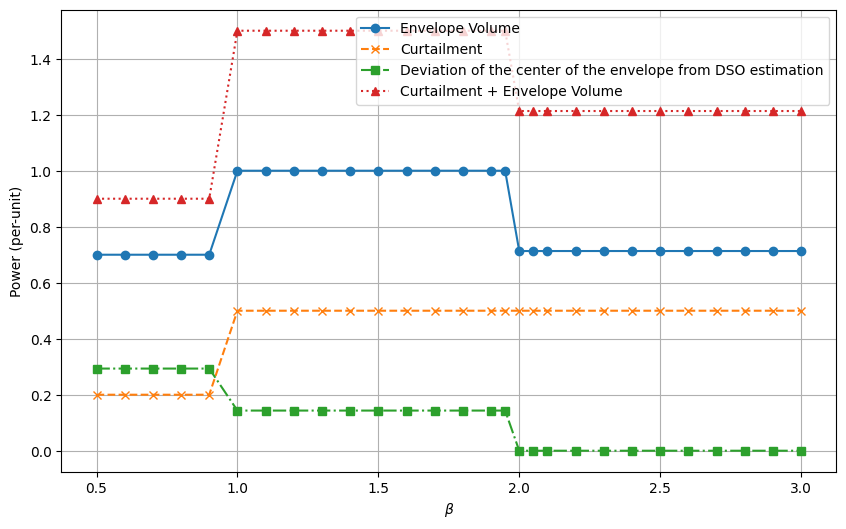

In [616]:
# Convert A to a numpy array for easier plotting
alpha_values = np.array(B)

# Convert lists to numpy arrays, replacing None with NaN for plotting
enveloppe_taille_np = np.array(enveloppe_taille, dtype=float)
curtail_np = np.array(curtail, dtype=float)
close_np = np.array(close, dtype=float)


plt.figure(figsize=(10, 6))

# Plot enveloppe_taille vs alpha
plt.plot(alpha_values, enveloppe_taille_np, marker='o', linestyle='-', label='Envelope Volume')

# Plot curtail vs alpha
plt.plot(alpha_values, curtail_np, marker='x', linestyle='--', label='Curtailment')

# Plot close vs alpha
plt.plot(alpha_values, close_np, marker='s', linestyle='-.', label='Deviation of the center of the envelope from DSO estimation')

plt.plot(alpha_values, somme_contributions, marker='^', linestyle=':', label='Curtailment + Envelope Volume')
# Set x-axis to a logarithmic scale
#plt.xscale('log')

# Save the plot as a PDF file


plt.xlabel('$\\beta$')
plt.ylabel('Power (per-unit)')
#plt.title(f'Evolution of the volume of the envelope, curtailment and closeness to estimation as a function of parameter $\\beta$ ($\\alpha$ = 2)')
plt.legend()
plt.grid(True)
plt.savefig('DOE_alloc_beta.pdf')

plt.show()

In [617]:
beta = 4
alpha = 2
enveloppe_taille = []
curtail = []
close = []


print(alpha)
def objective_rule(m):
  return  m.tot - alpha*m.O - beta * m.tot_bis
m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
           }
env = gp.Env(params=params)
solver = pyo.SolverFactory('gurobi', env= env)
results = solver.solve(m, tee=True)

  # Check the termination condition before accessing results
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
  curtail.append(m.O.value)
  enveloppe_taille.append(m.tot.value)
  close.append(m.tot_bis.value)

else:

      # Append None for non-optimal results to maintain list length
  curtail.append(None)
  enveloppe_taille.append(None)
  close.append(None)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpqiaqensj.pyomo.lp
Reading time = 0.00 seconds
x1: 474 rows, 179 columns, 844 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 474 rows, 179 columns and 844 nonzeros
Model fingerprint: 0xd8bde714
Coefficient statistics:
  Matrix range     [5e-01, 3e+01]
  Objective range  [1e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 416 rows and 116 columns
Presolve time: 0.01s
Presolved: 58 rows, 63 columns, 216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4981525e+01   1.372224e+02   0.

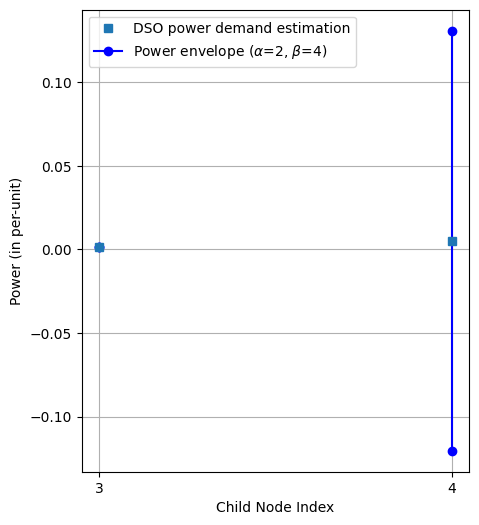

In [618]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
children_nodes = list(m.children)
p_c_set_0_values = [m.P_C_set[n, 0].value for n in m.children]
p_c_set_1_values = [m.P_C_set[n, 1].value for n in m.children]
info_dso_values = [m.info_DSO_param[n] for n in m.children]

# Create the plot
plt.figure(figsize=(5, 6))

# Adjust x_pos to control spacing (e.g., reduce the multiplier)
x_pos = np.arange(len(children_nodes)) * 0.0005 # Reduced spacing by multiplying by 0.0005

# Plot lines between P_C_set[n][0] and P_C_set[n][1] for each child node
for i in range(len(children_nodes)):
    plt.plot([x_pos[i], x_pos[i]], [p_c_set_1_values[i], p_c_set_0_values[i]], marker='o', linestyle='-', color='blue')

# Plot only dots for info_DSO_param
plt.plot(x_pos, info_dso_values, marker='s', linestyle='', label=f'DSO power demand estimation')

# Create legend handles for the P_C_set endpoints
# We plot invisible points with the desired labels to create legend entries
plt.plot([], [], marker='o', linestyle='-', color='blue', label=f'Power envelope ($\\alpha$={alpha}, $\\beta$={beta})')


plt.xticks(x_pos, children_nodes)
plt.xlabel('Child Node Index')
plt.ylabel('Power (in per-unit)')
#plt.title('Comparison of P_C_set values and DSO estimation for Child Nodes')
plt.legend(loc='upper left') # Move the legend to the upper left
plt.grid(True)

# Draw labels to the left of the points
# for i, n in enumerate(children_nodes):
#     # Label for the upper bound of the envelope
#     plt.text(x_pos[i], p_c_set_0_values[i], f"{round(p_c_set_0_values[i], 4)}", fontsize=8, ha='center', va='bottom', color='red')
#     # Label for the lower bound of the envelope
#     plt.text(x_pos[i], p_c_set_1_values[i], f"{round(p_c_set_1_values[i], 4)}", fontsize=8, ha='center', va='top', color='red')
#     # Label for the DSO estimation
#     plt.text(x_pos[i], info_dso_values[i], f"{round(info_dso_values[i], 4)}", fontsize=8, ha='center', va='center', color='green')


# Save the plot as a PDF file
plt.savefig('child_nodes_envelopes.pdf')

plt.show()

DOEs applied by DSOs

In [619]:
min_power_DSO = []
max_power_DSO = []
for n in m.children:
  max_power_DSO.append(m.P_C_set[n,0].value)
  min_power_DSO.append(m.P_C_set[n,1].value)

print(min_power_DSO)
print(max_power_DSO)

[0.00136, -0.1204025800307819]
[0.00136, 0.1308775800307819]


In [620]:
def create_digraph():
  net = pp.networks.case14()

  # Delete specified lines and transformer


  import json
  import networkx as nx
  import matplotlib.pyplot as plt
# 1. Conversion du réseau Pandapower en DiGraph
# ================================
  G = nx.Graph()

# Créer les positions à partir de la colonne "geo"
  pos = {}
  for idx, row in net.bus.iterrows():
  # Extraire le champ 'geo' qui est une chaîne de caractères représentant un dictionnaire JSON
      geo_data = row['geo']

  # Convertir la chaîne JSON en un dictionnaire Python
      geo_dict = json.loads(geo_data)

  # Extraire la liste des coordonnées
      coordinates = geo_dict["coordinates"]

  # Ajouter les coordonnées dans le dictionnaire pos
      pos[idx] = tuple(coordinates)  # Assigner les coordonnées sous forme de tuple

# Ajouter les nœuds (avec le nom comme label) and voltage
  for idx, row in net.bus.iterrows():
      G.add_node(idx, label=row["name"], pos=pos[idx], vn_kv=row["vn_kv"])


# Ajouter les arêtes pour les lines
  for _, row in net.line.iterrows():
      G.add_edge(row["from_bus"], row["to_bus"], type="line", name=row["name"], length=row["length_km"], std_type=row["std_type"])
      print(row["std_type"])

# Ajouter les arêtes pour les transformateurs
  for _, row in net.trafo.iterrows():
      G.add_edge(row["hv_bus"], row["lv_bus"], type="trafo", name=row["name"], std_type = None)

# Ajouter les générateurs et les charges comme attributs aux nœuds
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["type"] = "gen"
      G.nodes[row["bus"]]["gen_name"] = row["name"]
      G.nodes[row["bus"]]["gen_power"] = row["p_mw"]

  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["type"] = "load"
      G.nodes[row["bus"]]["load_name"] = row["name"]
      G.nodes[row["bus"]]["load_power"] = row["p_mw"]

  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["type"] = "ext_grid"
      G.nodes[row["bus"]]["grid_name"] = row["name"]

# 2. Ajout des puissances consommées et injectées aux nœuds
# ================================
  nx.set_node_attributes(G, 0.0, "P_load")
  nx.set_node_attributes(G, 0.0, "P_gen")

# Charges
  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["P_load"] += row["p_mw"]
      print(row)

# Générateurs
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["P_gen"] += row["p_mw"]

# Source externe
  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["P_gen"] += 0

# Calculate P_net
  for n in G.nodes:
      G.nodes[n]["P_net"] = G.nodes[n]["P_gen"] - G.nodes[n]["P_load"]

# Create subnetworks (NetworkX DiGraphs) from the main graph G
  #network1_buses = [0, 1, 2, 3,4]
  #network2_buses = [3, 6, 7, 8, 13]
  network3_buses = [4, 5, 9,10,11,12]

  G = G.subgraph(network3_buses)

  co = 4
  power_demand = {
        0: 0.0/co,
        1: -20,
        2: 50,
        3: 0/co,
        4: 0/co,
        5: -1e-1/co,
        6: 0.1/co,
        7: -0.2/co,
        8: -29.5*1e-2 /co,
        9: -9.0*1e-1 /co,
        10: -3.5*1e-1 /co,
        11: -6.1*1e-1 /co,
        12: -13.5*1e-2 /co,
        13: -14.9*1e-2 /co
    }
  for n in G.nodes:
      G.nodes[n]["P"] = power_demand[n] # Assign P_net to 'P' attribute
      G.nodes[n]["P_pu"] = G.nodes[n]["P"] / s_base

# 3. Préparer les couleurs des nœuds en fonction de P_net
# ================================
  node_colors = []
  for n, data in G.nodes(data=True):
      if data["P_net"] > 0:
          node_colors.append("green")   # producteur
      elif data["P_net"] < 0:
          node_colors.append("red")     # consommateur
      else:
          node_colors.append("gray")    # neutre

# 4. Préparer les labels : Nom + P_net
# ================================
  labels = {n: f"{data['label']}\nP={round(data['P_net'],2)}MW"
            for n, data in G.nodes(data=True)}

# 5. Function to plot the network
# ================================
  def plot_network():
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))
      nx.draw(
          G, pos,
          with_labels=True, labels=labels,
          node_size=1200, node_color=node_colors,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique test")
      plt.axis("equal")
      plt.show()


  return G, plot_network()

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
name                None
bus                    1
p_mw                21.7
q_mvar              12.7
const_z_percent      0.0
const_i_percent      0.0
sn_mva               NaN
scaling              1.0
in_service          True
type                None
controllable       False
Name: 0, dtype: object
name                None
bus                    2
p_mw                94.2
q_mvar              19.0
const_z_percent      0.0
const_i_percent      0.0
sn_mva               NaN
scaling              1.0
in_service          True
type                None
controllable       False
Name: 1, dtype: object
name                None
bus                    3
p_mw                47.8
q_mvar              -3.9
const_z_percent      0.0
const_i_percent      0.0
sn_mva               NaN
scaling              1.0
in_service          True
type                None
controllable       False
Name: 2, dtype: object
name                None
bus   

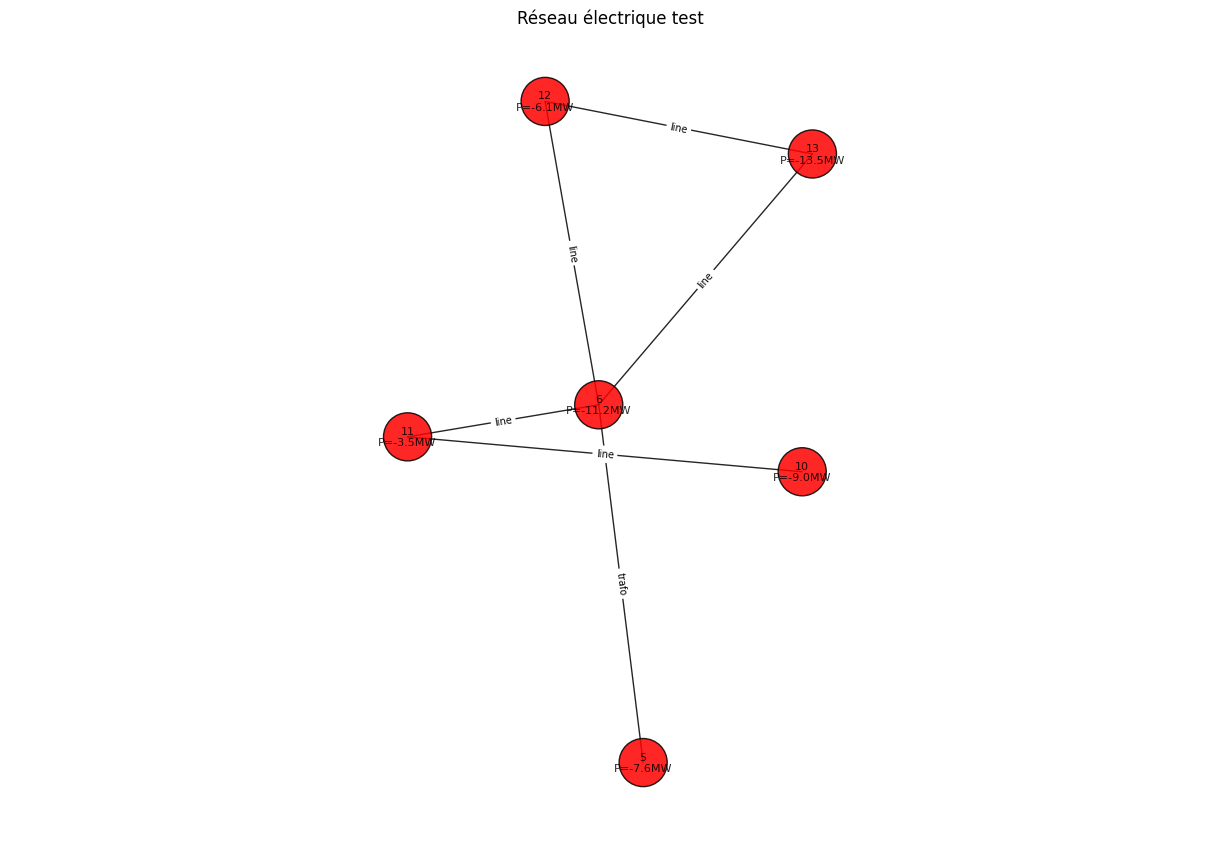

In [621]:
G, plot_func = create_digraph()

In [622]:
m = pyo.ConcreteModel()
# Define base values for the per-unit system
s_base = 100  # MVA
v_base_high = 110 # kV (From the create_network function)
first_parent = 4
m.Nodes = pyo.Set(initialize= [b for b in G.nodes])
m.Lines = pyo.Set(initialize= [l for l in G.edges])
m.i = pyo.Set(initialize=[0, 1]) # Initialize m.i with two generic elements
m.j = pyo.Set(initialize= [0, 1])
m.children = pyo.Set(initialize= [9,10,11,12])
m.parents = pyo.Set(initialize = [4])

m.P = pyo.Param(m.Nodes, initialize = {n: - G.nodes[n].get('P_pu') for n in G.nodes}, domain = pyo.Reals, mutable=True) # Make P mutable
m.P_absolute_value = pyo.Param(m.Nodes, initialize = {n: abs(m.P[n]) for n in G.nodes}, domain = pyo.NonNegativeReals) # Make P mutable

m.min_DSO = pyo.Param(m.parents, initialize = {n: min_power_DSO[n-first_parent]  for n in m.parents}, domain = pyo.Reals)
m.max_DSO = pyo.Param(m.parents, initialize = {n: max_power_DSO[n-first_parent]  for n in m.parents}, domain = pyo.Reals)

m.I_min = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.nodes[i]["vn_kv"])[0] for (i,j) in m.Lines}, domain = pyo.Reals)
m.I_max = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.nodes[i]["vn_kv"])[1] for (i,j) in m.Lines}, domain = pyo.Reals)


# Variables principales
m.F = pyo.Var(m.Lines, m.i, m.j, domain=pyo.Reals)     # active power flow through lines
m.I = pyo.Var(m.Lines,  m.i, m.j, domain=pyo.Reals)  # current flowing through lines
m.theta = pyo.Var(m.Nodes,  m.i, m.j, domain=pyo.Reals)  # phase angle of the voltage
m.V = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)  # voltage magnitude at each node
m.E = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals) #net power injection/consumption
m.P_plus = pyo.Var(m.parents, m.i, m.j, domain=pyo.Reals) #power entering the operational graph
m.P_minus = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals) #power leaving the operational graph

m.P_C_set = pyo.Var(m.children, m.i, domain=pyo.Reals) #vertices of the power envelope at each child node

#m.P_C_min = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals)
#m.P_C_max = pyo.Var(m.children, m.i, m.j,  domain=pyo.Reals)

m.V_P = pyo.Param(m.j, initialize = {0: 0.9, 1: 1.1}, domain =pyo.NonNegativeReals)

m.O = pyo.Var(domain= pyo.NonNegativeReals)
m.tot = pyo.Var(domain= pyo.Reals)
m.aux = pyo.Var(m.children, domain=pyo.Reals)
m.diff_DSO = pyo.Var(m.children, domain=pyo.NonNegativeReals)

for u in G.nodes():
  if G.nodes[u].get('P', 0.0) / s_base == 0:
    m.P[u] = 0
  else:
    G.nodes[u]['P_pu'] = G.nodes[u].get('P', 0.0) / s_base
    m.P[u] = - G.nodes[u]['P_pu']

m.info_DSO_param = pyo.Param(m.children, initialize = {n: m.P[n].value for n in m.children}, domain = pyo.Reals)
"""# Convert P parameter to per-unit
for n in G.nodes:
    # Assuming P is in MW, convert to per-unit
    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base
    m.P[n] = G.nodes[n]['P']"""

"# Convert P parameter to per-unit\nfor n in G.nodes:\n    # Assuming P is in MW, convert to per-unit\n    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base\n    m.P[n] = G.nodes[n]['P']"

In [623]:
#Children nodes consumption
def worst_case_children(m, n, vert_pow, vert_volt):
  return m.P_C_set[n, vert_pow] == m.P_minus[n, vert_pow, vert_volt]
m.worst_case = pyo.Constraint(m.children, m.i, m.j, rule=worst_case_children)


# Auxiliary variable for the absolute value of E (already defined as per-unit)
m.z = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)

m.curt = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals)

def curtailment_def_rule(m,n, vert_pow, vert_volt):

  return m.curt[n, vert_pow, vert_volt] == m.P[n] - m.E[n, vert_pow, vert_volt]

m.curt_def = pyo.Constraint(m.Nodes, m.i, m.j, rule=curtailment_def_rule)
# Constraints to define the absolute value (already defined for per-unit E)
def abs_E_pos_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= m.curt[n, vert_pow, vert_volt]
m.abs_E_pos = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_pos_rule)

def abs_E_neg_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= -m.curt[n, vert_pow, vert_volt]
m.abs_E_neg = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_neg_rule)

def upper_bound_rule(m, vert_pow, vert_volt):
    # m.z is per-unit, m.O is per-unit
    return sum(m.z[n, vert_pow, vert_volt] for n in m.Nodes) <= m.O

m.upper_bound = pyo.Constraint(m.i, m.j, rule=upper_bound_rule)

# Current magnitude constraint (I_min, I_max are assumed per-unit)
def current_bounds_rule(m, i, j, vert_pow, vert_volt):
    # m.I is per-unit current
    return pyo.inequality(m.I_min[(i,j)], m.I[i,j, vert_pow, vert_volt], m.I_max[(i,j)])
m.CurrentBounds = pyo.Constraint(m.Lines, m.i, m.j, rule=current_bounds_rule)

def phase_constr_rule(m,n, vert_pow, vert_volt):
    return pyo.inequality(theta_min, m.theta[n, vert_pow, vert_volt], theta_max)

m.phaseConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=phase_constr_rule)

def dc_power_flow_rule(m, i, j, vert_pow, vert_volt):
    if G[i][j].get('b_pu') is None:
      return pyo.Constraint.Skip
    else:
      return m.F[i, j, vert_pow, vert_volt] == m.V_P[vert_volt]**2 *(G[i][j]['b_pu'] * (
        m.theta[i, vert_pow, vert_volt] - m.theta[j, vert_pow, vert_volt])
    )

m.DCFlow = pyo.Constraint(m.Lines, m.i, m.j, rule=dc_power_flow_rule)


def current_def_rule(m, n, i, j, vert_pow, vert_volt):
    # This constraint relates per-unit current, per-unit voltage, and per-unit power flow.
    # In per-unit, P_pu = V_pu * I_pu. This is correct.
    return np.sqrt(3)* m.I[i,j, vert_pow, vert_volt] * m.V_P[vert_volt] == m.F[i,j, vert_pow, vert_volt]

m.current_def = pyo.Constraint(m.Nodes, m.Lines, m.i, m.j, rule=current_def_rule)



"""def nodes_balance(m, n, vert_pow, vert_volt):
    inflow = sum(m.F[k, n, vert_pow, vert_volt] for k in G.predecessors(n) if (k, n) in m.Lines)
    outflow = sum(m.F[n, j, vert_pow, vert_volt] for j in G.successors(n) if (n, j) in m.Lines)
    if n in m.parents:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]

    if n in m.children:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] + m.P_minus[n, vert_pow, vert_volt]

    else:
      return inflow - outflow ==  m.E[n,vert_pow,vert_volt]

m.nodes_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=nodes_balance)"""

def power_balance_rule(m, n, vert_pow, vert_volt):
    # Compute net flow into node n by summing over all lines (i,j) in m.Lines
    expr = sum(
        (m.F[i, j, vert_pow, vert_volt] if j == n else 0)
      - (m.F[i, j, vert_pow, vert_volt] if i == n else 0)
      for (i, j) in m.Lines
    )
    # If n is a parent node, subtract P_plus; otherwise use only E[n]
    if n in m.parents:
      return expr == m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]

    if n in m.children:
      return expr ==  m.E[n, vert_pow, vert_volt] + m.P_minus[n, vert_pow, vert_volt]
    else:
      return expr == m.E[n, vert_pow, vert_volt]

m.power_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=power_balance_rule)

print(m.min_DSO[4])
def parent_power_constraint_rule(m, parent, vert_pow, vert_volt):
    # m.P_plus is per-unit power entering the operational graph
    return pyo.inequality(min_power_DSO[1], m.P_plus[parent, vert_pow, vert_volt],max_power_DSO[1])

m.parent_power_constraint = pyo.Constraint(m.parents, m.i, m.j, rule=parent_power_constraint_rule)


#Constant voltage assumption
def voltage_constr_rule(m, n, vert_pow, vert_volt):
    return m.V[n, vert_pow, vert_volt] == m.V_P[vert_volt]

m.voltageConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=voltage_constr_rule)

def children_voltage_rule(m, children, vert_pow, vert_volt):
    return pyo.inequality(V_min, m.V[children, vert_pow, vert_volt], V_max)

m.children_voltage = pyo.Constraint(m.children, m.i, m.j, rule=children_voltage_rule)

"""def dernier_chance_rule(m, child, vert_pow, vert_volt):
    return  m.P_minus[child, vert_pow, vert_volt] >=0
m.dernier_chance = pyo.Constraint(m.children, m.i, m.j, rule=dernier_chance_rule)"""
def aux_constraint_rule(m, n):
  return m.aux[n] == m.P_C_set[n, 0] - m.P_C_set[n, 1]
m.aux_constraint = pyo.Constraint(m.children, rule=aux_constraint_rule)

"""def logical_constraint_rule(m, n):
  return m.P_C_set[n, 0] >= m.P_C_set[n, 1]
m.logical_constraint = pyo.Constraint(m.children, rule=logical_constraint_rule)"""

"""def info_DSO_min_rule(m,n):
  return m.P_C_set[n,1] <= m.info_DSO_param[n]
m.info_DSO_min = pyo.Constraint(m.children, rule=info_DSO_min_rule)

def info_DSO_max_rule(m,n):
  return m.P_C_set[n,0] >= m.info_DSO_param[n]
m.info_DSO_max = pyo.Constraint(m.children, rule=info_DSO_max_rule)"""

def tot_rule(m):
  return m.tot == sum(m.aux[n] for n in m.children)
m.tot_constraint = pyo.Constraint(rule=tot_rule)

def diff_DSO_rule(m,n):
  return - m.diff_DSO[n] <= (m.P_C_set[n,0] + m.P_C_set[n,1])/2 - m.info_DSO_param[n]
m.diff_DSO_constraint = pyo.Constraint(m.children, rule=diff_DSO_rule)

def diff_bis_dso_rule(m,n):
  return (m.P_C_set[n,0] + m.P_C_set[n,1])/2 - m.info_DSO_param[n] <= m.diff_DSO[n]
m.diff_bis_dso_constraint = pyo.Constraint(m.children, rule=diff_bis_dso_rule)


m.abs_diff_DSO = pyo.Var(m.children, domain=pyo.NonNegativeReals)
"""def abs_different_rule(m, n):
    return  m.abs_diff_DSO[n] >= -m.diff_DSO[n]
m.abs_different = pyo.Constraint(m.children, rule=abs_different_rule)

def abs_different_bis_rule(m, n):
    return  m.abs_diff_DSO[n] >= m.diff_DSO[n]
m.abs_different = pyo.Constraint(m.children, rule=abs_different_rule)"""

m.tot_bis = pyo.Var(domain=pyo.Reals)
def tot_bis_rule(m):
  return m.tot_bis == sum(m.diff_DSO[n] for n in m.children)
m.tot_bis_constraint = pyo.Constraint(rule=tot_bis_rule)

# Build sets based on sign of parameter P
m.PositiveNodes = pyo.Set(initialize=[n for n in m.Nodes if pyo.value(m.P[n]) >= 0])
m.NegativeNodes = pyo.Set(initialize=[n for n in m.Nodes if pyo.value(m.P[n]) <= 0])

# Constraint for positive P: upper bound
def net_power_upper_rule(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] <= m.P[n]
m.net_power_upper = pyo.Constraint(m.PositiveNodes, m.i, m.j, rule=net_power_upper_rule)

def sign_E_rule(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] >= 0

m.sign_E = pyo.Constraint(m.PositiveNodes, m.i, m.j, rule=sign_E_rule)



# Constraint for negative P: lower bound
def net_power_lower_rule(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] >= m.P[n]
m.net_power_lower = pyo.Constraint(m.NegativeNodes, m.i, m.j, rule=net_power_lower_rule)

def sign_E_lower_rule(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] <= 0

m.sign_E_lower = pyo.Constraint(m.NegativeNodes, m.i, m.j, rule=sign_E_lower_rule)

"""m.PositiveNodes = pyo.Set(initialize=[n for n in m.Nodes if m.P[n] >= 0])
m.NegativeNodes = pyo.Set(initialize=[n for n in m.Nodes if m.P[n] <= 0])

# Constraint for positive P: upper bound
def net_power_upper(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] <= m.P[n]
m.net_power_upper = pyo.Constraint(m.PositiveNodes, m.i, m.j, rule=net_power_upper)

# Constraint for negative P: lower bound
def net_power_lower(m, n, vert_pow, vert_volt):
    return m.E[n, vert_pow, vert_volt] >= m.P[n]
m.net_power_lower = pyo.Constraint(m.NegativeNodes, m.i, m.j, rule=net_power_lower)"""

"""# Auxiliary variables for the L1 norm of P_C_set
m.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)

# Constraints to linearize the L1 norm of P_C_set
def abs_P_C_set_pos_rule(m, n):
    return m.abs_P_C_set[n] >= m.aux[n]
m.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)

def abs_P_C_set_neg_rule(m, n):
    return m.abs_P_C_set[n] >= -m.aux[n]
m.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)"""

0.00136


'# Auxiliary variables for the L1 norm of P_C_set\nm.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)\n\n# Constraints to linearize the L1 norm of P_C_set\ndef abs_P_C_set_pos_rule(m, n):\n    return m.abs_P_C_set[n] >= m.aux[n]\nm.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)\n\ndef abs_P_C_set_neg_rule(m, n):\n    return m.abs_P_C_set[n] >= -m.aux[n]\nm.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)'

In [629]:
beta = 3
alpha = 4
enveloppe_taille = []
curtail = []
close = []


print(alpha)
def objective_rule(m):
  return  m.tot - alpha*m.O - beta * m.tot_bis
m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
           }
env = gp.Env(params=params)
solver = pyo.SolverFactory('gurobi', env= env)
results = solver.solve(m, tee=True)

  # Check the termination condition before accessing results
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
  curtail.append(m.O.value)
  enveloppe_taille.append(m.tot.value)
  close.append(m.tot_bis.value)

else:

      # Append None for non-optimal results to maintain list length
  curtail.append(None)
  enveloppe_taille.append(None)
  close.append(None)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


4
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp65dovzma.pyomo.lp
Reading time = 0.00 seconds
x1: 490 rows, 207 columns, 846 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 490 rows, 207 columns and 846 nonzeros
Model fingerprint: 0xe6df664b
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 2e+00]
Presolve removed 468 rows and 163 columns
Presolve time: 0.00s
Presolved: 22 rows, 44 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5920000e-04   6.150899e-02   0.

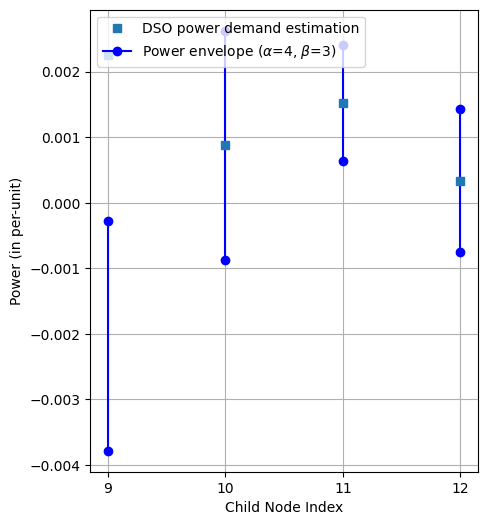

In [630]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
children_nodes = list(m.children)
p_c_set_0_values = [m.P_C_set[n, 0].value for n in m.children]
p_c_set_1_values = [m.P_C_set[n, 1].value for n in m.children]
info_dso_values = [m.info_DSO_param[n] for n in m.children]

# Create the plot
plt.figure(figsize=(5, 6))

# Adjust x_pos to control spacing (e.g., reduce the multiplier)
x_pos = np.arange(len(children_nodes)) * 0.0005 # Reduced spacing by multiplying by 0.0005

# Plot lines between P_C_set[n][0] and P_C_set[n][1] for each child node
for i in range(len(children_nodes)):
    plt.plot([x_pos[i], x_pos[i]], [p_c_set_1_values[i], p_c_set_0_values[i]], marker='o', linestyle='-', color='blue')

# Plot only dots for info_DSO_param
plt.plot(x_pos, info_dso_values, marker='s', linestyle='', label=f'DSO power demand estimation')

# Create legend handles for the P_C_set endpoints
# We plot invisible points with the desired labels to create legend entries
plt.plot([], [], marker='o', linestyle='-', color='blue', label=f'Power envelope ($\\alpha$={alpha}, $\\beta$={beta})')


plt.xticks(x_pos, children_nodes)
plt.xlabel('Child Node Index')
plt.ylabel('Power (in per-unit)')
#plt.title('Comparison of P_C_set values and DSO estimation for Child Nodes')
plt.legend(loc='upper left') # Move the legend to the upper left
plt.grid(True)

# Draw labels to the left of the points
# for i, n in enumerate(children_nodes):
#     # Label for the upper bound of the envelope
#     plt.text(x_pos[i], p_c_set_0_values[i], f"{round(p_c_set_0_values[i], 4)}", fontsize=8, ha='center', va='bottom', color='red')
#     # Label for the lower bound of the envelope
#     plt.text(x_pos[i], p_c_set_1_values[i], f"{round(p_c_set_1_values[i], 4)}", fontsize=8, ha='center', va='top', color='red')
#     # Label for the DSO estimation
#     plt.text(x_pos[i], info_dso_values[i], f"{round(info_dso_values[i], 4)}", fontsize=8, ha='center', va='center', color='green')


# Save the plot as a PDF file
plt.savefig('child_nodes_envelopes.pdf')

plt.show()

In [626]:
# Print values of m.I
print("Values of m.I:")
for line in m.Lines:
    u, v = line
    for vert_pow in m.i:
        for vert_volt in m.j:
            try:
                print(f"m.I[{u},{v},{vert_pow},{vert_volt}].value: {m.I[u, v, vert_pow, vert_volt].value}")
            except:
                print(f"m.I[{u},{v},{vert_pow},{vert_volt}].value: None")


# Print values of m.I_max
print("\nValues of m.I_max:")
for (u, v) in m.Lines:
  print(m.I_max[(u,v)])

Values of m.I:
m.I[4,5,0,0].value: 0.003943174038505324
m.I[4,5,0,1].value: 0.0032262333042316284
m.I[4,5,1,0].value: -0.003622423888955531
m.I[4,5,1,1].value: -0.002963801363690889
m.I[5,10,0,0].value: 0.0012609329879101423
m.I[5,10,0,1].value: 0.0010316724446537528
m.I[5,10,1,0].value: -0.0012609329879101423
m.I[5,10,1,1].value: -0.0010316724446537528
m.I[5,11,0,0].value: 0.0012609329879101423
m.I[5,11,0,1].value: 0.0008024119013973634
m.I[5,11,1,0].value: -0.0012609329879101423
m.I[5,11,1,1].value: -0.0012609329879101423
m.I[5,12,0,0].value: 0.0012609329879101423
m.I[5,12,0,1].value: 0.0012609329879101423
m.I[5,12,1,0].value: -0.0012609329879101423
m.I[5,12,1,1].value: -0.0008024119013973634
m.I[9,10,0,0].value: -0.0012609329879101423
m.I[9,10,0,1].value: -0.0010316724446537528
m.I[9,10,1,0].value: -0.0012609329879101423
m.I[9,10,1,1].value: -0.0010316724446537528
m.I[11,12,0,0].value: -0.0012609329879101423
m.I[11,12,0,1].value: -0.0012609329879101423
m.I[11,12,1,0].value: -0.00126